In [1]:
import sys
if '..' not in sys.path:
    sys.path.append('..')

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import USPS

import matplotlib.pyplot as plt
import numpy as np

from source.models import AE
from source.data import get_train_test_dataloaders
from source.eval import eval_loss

from functools import partial
import copy
import math
import gc
from tqdm import tqdm
# from multiprocessing import Pool
import torch.multiprocessing as mp
from collections import OrderedDict

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = 'cpu'

/home/daria.cherniuk/.conda/eve3/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def plot_progress(x, z):
    rows = 4
    cols = 16
    fig, ax = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(cols, rows))
    for i in range(len(x)):
        ax[i//cols, i%cols].imshow(x[i].cpu().reshape([16, 16]), 'gray')
        ax[i//cols, i%cols].set_axis_off()
    for i in range(len(z)):
        ax[i//cols+2, i%cols].imshow(z[i].detach().cpu().numpy().reshape([16, 16]), 'gray')
        ax[i//cols+2, i%cols].set_axis_off()
    plt.show()

In [4]:
train_loader, test_loader = get_train_test_dataloaders('..', 'USPS', 
                                                       batch_size=7291, 
                                                       drop_last=False,
                                                       num_workers=4)
len(train_loader), len(test_loader)

(1, 1)

In [5]:
model = AE().to(device)
loss_function = torch.nn.MSELoss()
print('Random-initialized model loss: '
      f'{eval_loss(model, test_loader, loss_function, device=device)}')

Random-initialized model loss: 0.16190466284751892


Random-initialized model reconstruction results:


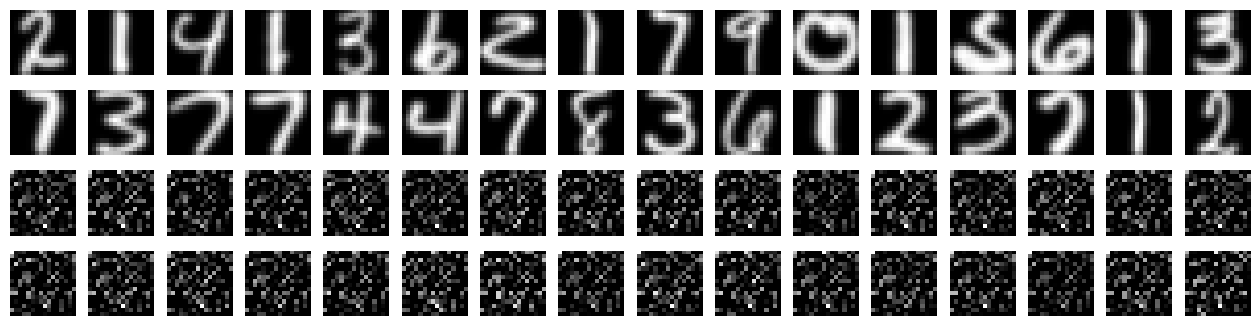

In [15]:
for x, _ in train_loader:
    x = x[:32].to(device)
    with torch.no_grad():
        z = model(x)
    
    print('Random-initialized model reconstruction results:')
    plot_progress(x, z)
    
    break

In [16]:
CACHE_OUTPUTS = {}
CACHE_RELUS = {}

def cache_relu_hook(idx, module, input, output):
    CACHE_RELUS[idx] = output.detach().cpu()
    
def cache_output_hook(idx, module, input, output):
    CACHE_OUTPUTS[idx] = output.detach().cpu()

i, j = 0 , 0
relu_handles = []
for m in model.modules():
    if isinstance(m, nn.ReLU):
        handle = m.register_forward_hook(partial(cache_relu_hook, i))
        i += 1
        relu_handles.append(handle)
    # elif isinstance(m, nn.Linear):
    #     handle = m.register_forward_hook(partial(cache_output_hook, j))
    #     j += 1
        
# caching activations
with torch.no_grad():
    for x, _ in train_loader:
        x = x.to(device)
        _ = model(x)
        x = x.cpu()
        
# sized of cached activattions
for i in range(len(CACHE_RELUS)):
    print(CACHE_RELUS[i].shape)

torch.Size([7291, 300])
torch.Size([7291, 100])
torch.Size([7291, 20])
torch.Size([7291, 100])
torch.Size([7291, 300])
torch.Size([7291, 256])


In [17]:
for m in model.modules():
    if isinstance(m, nn.ReLU):
        m._forward_hooks = OrderedDict()
        
eval_loss(model, test_loader, loss_function, device=device)

0.16206783056259155

In [18]:
for i in range(len(CACHE_RELUS)):
    print(CACHE_RELUS[i].shape)

torch.Size([7291, 300])
torch.Size([7291, 100])
torch.Size([7291, 20])
torch.Size([7291, 100])
torch.Size([7291, 300])
torch.Size([7291, 256])


In [19]:
WEIGHTS = [
    model.encoder[0].weight.detach().cpu(),
    model.encoder[2].weight.detach().cpu(),
    model.encoder[4].weight.detach().cpu(),
    model.decoder[0].weight.detach().cpu(),
    model.decoder[2].weight.detach().cpu(),
    model.decoder[4].weight.detach().cpu(),
]

# sum of all output shapes
H = 0
h_k = [0]
for W in WEIGHTS:
    H += W.shape[0]
    h_k.append(W.shape[0] + h_k[-1])
h_k = h_k[1:]
H, h_k

(1076, [300, 400, 420, 520, 820, 1076])

In [20]:
# simple autoencoder model
model

AE(
  (encoder): Sequential(
    (0): Linear(in_features=256, out_features=300, bias=False)
    (1): ReLU()
    (2): Linear(in_features=300, out_features=100, bias=False)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=20, bias=False)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=100, bias=False)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=300, bias=False)
    (3): ReLU()
    (4): Linear(in_features=300, out_features=256, bias=False)
    (5): ReLU()
  )
)

# Gauss-Newton

## gpu, torch, J cut

In [5]:
device = 'cuda'

In [6]:
def calculate_z_residuals(cache_relus, x, h_k, WEIGHTS):
    
    relu = nn.ReLU()
    
    residuals = torch.zeros(h_k[-1])
    start = 0
    for layer_idx in range(len(h_k)):
        if layer_idx == 0:
            residuals[start:h_k[layer_idx]] = cache_relus[start:h_k[layer_idx]] - relu(torch.einsum('q,hq->h', x, WEIGHTS[layer_idx]))
        elif layer_idx == 1:
            residuals[start:h_k[layer_idx]] = cache_relus[start:h_k[layer_idx]] \
                                              - relu(torch.einsum('q,hq->h', cache_relus[:h_k[layer_idx-1]], 
                                                                             WEIGHTS[layer_idx]))
        elif layer_idx == len(h_k) - 1:
            residuals[start:h_k[layer_idx]] = x - relu(torch.einsum('q,hq->h', cache_relus[h_k[layer_idx-2]:h_k[layer_idx-1]], WEIGHTS[layer_idx]))
        else:
            residuals[start:h_k[layer_idx]] = cache_relus[start:h_k[layer_idx]] \
                                              - relu(torch.einsum('q,hq->h', cache_relus[h_k[layer_idx-2]:h_k[layer_idx-1]], 
                                                                             WEIGHTS[layer_idx]))
        start = h_k[layer_idx]
    return residuals

def z_step(n_sample, cache_relus, x, WEIGHTS, mu, h_k):
    
    # Calculating Residuals
    residuals = calculate_z_residuals(cache_relus, x, h_k, WEIGHTS)
    
    # Quadratic Penalty
    assert len(residuals) == h_k[-1]
    # Quadratic Penalty
    mu_mult = torch.ones_like(residuals)
    mu_mult[:h_k[-2]] = math.sqrt(mu)
    residuals = mu_mult * residuals

    # Building Jacobian for each sample in dataset
    J = torch.zeros((h_k[-1], h_k[-2]))
    for h in range(h_k[-1]):
        if h < h_k[-2]: J[h, h] = mu
        for layer_idx in range(len(h_k)):
            if h < h_k[layer_idx]: break
        if layer_idx == 0: continue

        n_feature = h-h_k[layer_idx-1]
        assert n_feature >= 0 and n_feature < WEIGHTS[layer_idx].shape[0]

        if layer_idx == 1:
            start, finish = 0, h_k[layer_idx-1]
        elif layer_idx > 1:
            start, finish = h_k[layer_idx-2], h_k[layer_idx-1]
        if cache_relus[h] > 0:
            J[h, start:finish] = - WEIGHTS[layer_idx][n_feature]
            # Quadratic Penalty
            if layer_idx != len(h_k)-1:
                J[h, start:finish] *= mu

    # Descent Direction
    p = torch.linalg.lstsq(J.T@J, - J.T @ residuals, rcond=None)[0]
    # p.T @ grad (.T doesn't matter, numpy performs inner product)
    descent_inner_prod = (J.T @ residuals) @ p
    try:
        assert descent_inner_prod <= 0
    except:
        print(f'sample {n_sample} descent direction should be <= 0', descent_inner_prod)

    # Line Search with Backtracking
    p_ = torch.zeros(h_k[-1])
    p_[:h_k[-2]] = p
    alpha = 1.0
    fw = residuals.sum() / 2
    # recompute residuals with relus update
    residuals_new = calculate_z_residuals(cache_relus + alpha * p_, x, h_k, WEIGHTS)

    # Quadratic Penalty
    residuals_new = mu_mult * residuals_new
    fw_new = (residuals_new**2).sum() / 2
    rhs = alpha * line_search_c * descent_inner_prod

    max_iter, counter = 40, 0
    # Armijo Condition
    while fw_new - fw > rhs and counter < max_iter:
        # step update
        alpha *= line_search_tau

        # recompute residuals with new relus update
        residuals_new = calculate_z_residuals(cache_relus + alpha * p_, x, h_k, WEIGHTS)

        # Quadratic Penalty
        residuals_new = mu_mult * residuals_new
        fw_new = (residuals_new**2).sum() / 2
        rhs = alpha * line_search_c * descent_inner_prod

        # print("Line search armijo: obj func old: %f new: %f diff: %.16f rhs: %.16f, alpha: %f" % (fw, fw_new, fw_new - fw, rhs, alpha))
        counter += 1
     
    return J, cache_relus + alpha * p_

In [7]:
def calculate_w_residuals(layer_idx, h, w_h, x, CACHE_RELUS):
    
    relu = nn.ReLU()
    
    if layer_idx == 0:
        residuals = CACHE_RELUS[layer_idx][:,h] - relu(torch.einsum('bq,q->b', x, w_h))
    elif layer_idx == len(CACHE_RELUS) - 1:
        residuals = x[:,h] - relu(torch.einsum('bq,q->b', CACHE_RELUS[layer_idx-1], w_h))
    else:
        residuals = CACHE_RELUS[layer_idx][:,h] - relu(torch.einsum('bq,q->b', CACHE_RELUS[layer_idx-1], w_h))
        
    return residuals

def w_step(layer_idx, h, w_h, x, CACHE_RELUS, n_samples):
    residuals = calculate_w_residuals(layer_idx, h, w_h, x, CACHE_RELUS)
    
    # Building Jacobian (for each layer and output dim)
    J = torch.zeros((n_samples, len(w_h)))

    if layer_idx == 0:
        for n in range(n_samples):
            if CACHE_RELUS[layer_idx][n][h] > 0:
                J[n, :] = - x[n]
    else:
        for n in range(n_samples):
            if CACHE_RELUS[layer_idx][n][h] > 0:
                J[n, :] = - CACHE_RELUS[layer_idx-1][n]

    p = torch.linalg.lstsq(J.T@J, - J.T @ residuals, rcond=None)[0]
    # p.T @ grad (.T doesn't matter, numpy performs inner product)
    descent_inner_prod = (J.T @ residuals) @ p
    try:
        assert descent_inner_prod <= 0
    except:
        # pass
        print(f'layer {layer_idx+1} dim {h} descent(should be <= 0)', descent_inner_prod)

    # Line Search with Backtracking
    alpha = 1.0
    fw = (residuals**2).sum() / 2
    # First Update
    residuals_new = calculate_w_residuals(layer_idx, h, w_h + alpha*p, x, CACHE_RELUS)
    fw_new = (residuals_new**2).sum() / 2
    rhs = alpha * line_search_c * descent_inner_prod

    max_iter, counter = 40, 0
    # Armijo Condition
    while fw_new - fw > rhs and counter < max_iter:
        alpha *= line_search_tau
        # Update
        residuals_new = calculate_w_residuals(layer_idx, h, w_h + alpha*p, x, CACHE_RELUS)
        fw_new = (residuals_new**2).sum() / 2
        rhs = alpha * line_search_c * descent_inner_prod

        # print("Line search armijo: obj func old: %f new: %f diff: %.16f rhs: %.16f, alpha: %f" % (fw, fw_new, fw_new - fw, rhs, alpha))
        counter += 1
        
    return w_h + alpha*p

In [8]:
%%time

relu = nn.ReLU()

line_search_c = pow(10,-4)
# backtracking multiplier
line_search_tau = 0.5

# Quadratic Penalty multiplier 
mu = 1.0

loss_function = torch.nn.MSELoss()
loss_hist = []

# creating model
model = AE().to(device)
loss = eval_loss(model, test_loader, loss_function, device=device)
loss_hist.append(loss)
print(f'Random-initialized model loss: {loss}')

WEIGHTS = [
    model.encoder[0].weight.detach().cpu(),
    model.encoder[2].weight.detach().cpu(),
    model.encoder[4].weight.detach().cpu(),
    model.decoder[0].weight.detach().cpu(),
    model.decoder[2].weight.detach().cpu(),
    model.decoder[4].weight.detach().cpu(),
]

# all output shapes
h_k = [0]
for W in WEIGHTS:
    h_k.append(W.shape[0] + h_k[-1])
h_k = h_k[1:]

# registering hooks to cache activations
CACHE_RELUS = {}

def cache_relu_hook(idx, module, input, output):
    CACHE_RELUS[idx] = output.detach().cpu()

i = 0 
for m in model.modules():
    if isinstance(m, nn.ReLU):
        handle = m.register_forward_hook(partial(cache_relu_hook, i))
        i += 1
        
# caching activations
with torch.no_grad():
    for x, _ in train_loader:
        x = x.to(device)
        _ = model(x)
        x = x.detach().cpu()
        
# Removing Hooks
for m in model.modules():
    if isinstance(m, nn.ReLU):
        m._forward_hooks = OrderedDict()
        
def _get_cached_relus(n_sample):
    cache_relus = torch.zeros(h_k[-1])
    start = 0
    for layer_idx in range(len(h_k)):
        cache_relus[start:h_k[layer_idx]] = CACHE_RELUS[layer_idx][n_sample]
        start = h_k[layer_idx]
    return cache_relus

n_samples = x.shape[0]
print('n samples:', n_samples)
        
with torch.no_grad():
    for epoch in range(10):
        
        # W-Step
        WEIGHTS_COPY = copy.deepcopy(WEIGHTS)

        for layer_idx in tqdm(range(len(h_k))):

            for h in range(WEIGHTS[layer_idx].shape[0]):
            # for h in range(5):
                w_h = WEIGHTS[layer_idx][h]
                new_w_h = w_step(layer_idx, h, w_h, x, CACHE_RELUS, n_samples)
                WEIGHTS[layer_idx][h] = new_w_h
                    
        # Checking Norm Difference
        for layer_idx in range(len(h_k)):
            print(f'Layer {layer_idx}, '
                  f'Weights Diff Norm (%): {torch.linalg.norm(WEIGHTS[layer_idx]-WEIGHTS_COPY[layer_idx]) / torch.linalg.norm(WEIGHTS_COPY[layer_idx])}')
        
        # Loading weights back to model to compute eval loss
        model.encoder[0].weight.data = WEIGHTS[0]
        model.encoder[2].weight.data = WEIGHTS[1]
        model.encoder[4].weight.data = WEIGHTS[2]
        model.decoder[0].weight.data = WEIGHTS[3]
        model.decoder[2].weight.data = WEIGHTS[4]
        model.decoder[4].weight.data = WEIGHTS[5]
        model = model.to(device)
        
        # Loss on eval dataset
        loss = eval_loss(model, test_loader, loss_function, device=device)
        loss_hist.append(loss)
        print(f'Epoch {epoch+1}, Eval loss: {loss}')
        
        # Updating Quandratic Penalty Multiplier
        if abs(loss_hist[-2] - loss_hist[-1]) < 1e-2:
            mu *= 4
            print(f'New MU: {mu}')
        
        # # recalculating activations after weights update
        # for x, _ in train_loader:
        #     x = x.to(device)
        #     _ = model(x)
        #     x = x.cpu()
    
        # Z-Step
        CACHE_RELUS_COPY = copy.deepcopy(CACHE_RELUS)
        
        # process for each sample
        for n_sample in tqdm(range(n_samples)):
            J, new_relus = z_step(n_sample, _get_cached_relus(n_sample), x[n_sample], WEIGHTS, mu, h_k)
            start = 0
            for layer_idx in range(len(h_k)):
                CACHE_RELUS[layer_idx][n_sample] = new_relus[start:h_k[layer_idx]]
                start = h_k[layer_idx]

        # Computing Relus Norm Difference
        for layer_idx in range(len(CACHE_RELUS)):
            print(f'Layer {layer_idx} Activations Diff Norm (%): '
                  f'{torch.linalg.norm(CACHE_RELUS[layer_idx]-CACHE_RELUS_COPY[layer_idx]) / torch.linalg.norm(CACHE_RELUS_COPY[layer_idx])}')
           
        # print()

Random-initialized model loss: 0.1622152030467987
n samples: 7291


100%|██████████| 6/6 [01:54<00:00, 19.10s/it]

Layer 0, Weights Diff Norm (%): 0.00011375769099686295
Layer 1, Weights Diff Norm (%): 3.034640940313693e-05
Layer 2, Weights Diff Norm (%): 9.182318899547681e-05
Layer 3, Weights Diff Norm (%): 0.00020549503096845
Layer 4, Weights Diff Norm (%): 0.00013512941950466484
Layer 5, Weights Diff Norm (%): 55.55363845825195


Epoch 1, Eval loss: 0.06062563136219978


100%|██████████| 7291/7291 [06:28<00:00, 18.78it/s]


Layer 0 Activations Diff Norm (%): 0.0010140194790437818
Layer 1 Activations Diff Norm (%): 0.008522992953658104
Layer 2 Activations Diff Norm (%): 0.13773000240325928
Layer 3 Activations Diff Norm (%): 0.6360561847686768
Layer 4 Activations Diff Norm (%): 1.4921358823776245
Layer 5 Activations Diff Norm (%): 0.0


100%|██████████| 6/6 [02:07<00:00, 21.29s/it]

Layer 0, Weights Diff Norm (%): 4.05544851673767e-05
Layer 1, Weights Diff Norm (%): 6.136705633252859e-05
Layer 2, Weights Diff Norm (%): 0.009201987646520138
Layer 3, Weights Diff Norm (%): 0.5401328206062317
Layer 4, Weights Diff Norm (%): 1.0474711656570435
Layer 5, Weights Diff Norm (%): 1.253659725189209


Epoch 2, Eval loss: 0.049894750118255615


100%|██████████| 7291/7291 [06:51<00:00, 17.70it/s]


Layer 0 Activations Diff Norm (%): 0.0002965646854136139
Layer 1 Activations Diff Norm (%): 0.0016334662213921547
Layer 2 Activations Diff Norm (%): 0.01872045360505581
Layer 3 Activations Diff Norm (%): 0.01411974336951971
Layer 4 Activations Diff Norm (%): 0.14771169424057007
Layer 5 Activations Diff Norm (%): 0.0


100%|██████████| 6/6 [02:07<00:00, 21.30s/it]

Layer 0, Weights Diff Norm (%): 1.659515874052886e-05
Layer 1, Weights Diff Norm (%): 1.6687001334503293e-05
Layer 2, Weights Diff Norm (%): 0.002850422402843833
Layer 3, Weights Diff Norm (%): 0.1374271810054779
Layer 4, Weights Diff Norm (%): 0.5658919215202332
Layer 5, Weights Diff Norm (%): 0.37969163060188293


Epoch 3, Eval loss: 0.05132470652461052
New MU: 4.0


100%|██████████| 7291/7291 [06:31<00:00, 18.62it/s]


Layer 0 Activations Diff Norm (%): 0.00021949740767013282
Layer 1 Activations Diff Norm (%): 0.002181676449254155
Layer 2 Activations Diff Norm (%): 0.03390323370695114
Layer 3 Activations Diff Norm (%): 0.10305183380842209
Layer 4 Activations Diff Norm (%): 0.2025727778673172
Layer 5 Activations Diff Norm (%): 0.0


  0%|          | 0/6 [00:00<?, ?it/s]

layer 1 dim 133 descent(should be <= 0) tensor(3.8477e-09)


 17%|█▋        | 1/6 [00:37<03:09, 37.91s/it]

layer 2 dim 60 descent(should be <= 0) tensor(4.3048e-07)


100%|██████████| 6/6 [02:08<00:00, 21.48s/it]

Layer 0, Weights Diff Norm (%): 1.0459329132572748e-05
Layer 1, Weights Diff Norm (%): 1.883784352685325e-05
Layer 2, Weights Diff Norm (%): 0.002079098718240857
Layer 3, Weights Diff Norm (%): 0.08837150782346725
Layer 4, Weights Diff Norm (%): 0.1449817568063736
Layer 5, Weights Diff Norm (%): 0.18018628656864166


Epoch 4, Eval loss: 0.05128522589802742
New MU: 16.0


100%|██████████| 7291/7291 [06:17<00:00, 19.32it/s]


Layer 0 Activations Diff Norm (%): 7.427079981425777e-05
Layer 1 Activations Diff Norm (%): 0.0008433430339209735
Layer 2 Activations Diff Norm (%): 0.013475336134433746
Layer 3 Activations Diff Norm (%): 0.03352133929729462
Layer 4 Activations Diff Norm (%): 0.07446892559528351
Layer 5 Activations Diff Norm (%): 0.0


  0%|          | 0/6 [00:00<?, ?it/s]

layer 1 dim 66 descent(should be <= 0) tensor(1.5045e-09)


 17%|█▋        | 1/6 [00:37<03:09, 37.87s/it]

layer 2 dim 33 descent(should be <= 0) tensor(4.0254e-09)
layer 2 dim 60 descent(should be <= 0) tensor(5.3424e-07)
layer 2 dim 71 descent(should be <= 0) tensor(2.1814e-08)


100%|██████████| 6/6 [02:09<00:00, 21.61s/it]

Layer 0, Weights Diff Norm (%): 1.2910584700875916e-05
Layer 1, Weights Diff Norm (%): 8.965971574070863e-06
Layer 2, Weights Diff Norm (%): 0.0017115233931690454
Layer 3, Weights Diff Norm (%): 0.031035631895065308
Layer 4, Weights Diff Norm (%): 0.05854717269539833
Layer 5, Weights Diff Norm (%): 0.08065084367990494


Epoch 5, Eval loss: 0.05135723203420639
New MU: 64.0


100%|██████████| 7291/7291 [06:30<00:00, 18.68it/s]


Layer 0 Activations Diff Norm (%): 3.6603244097932475e-06
Layer 1 Activations Diff Norm (%): 2.9451444788719527e-05
Layer 2 Activations Diff Norm (%): 0.0004216606030240655
Layer 3 Activations Diff Norm (%): 0.0017028714064508677
Layer 4 Activations Diff Norm (%): 0.0026814418379217386
Layer 5 Activations Diff Norm (%): 0.0


  0%|          | 0/6 [00:00<?, ?it/s]

layer 1 dim 145 descent(should be <= 0) tensor(1.4878e-10)
layer 1 dim 196 descent(should be <= 0) tensor(1.3563e-09)
layer 1 dim 202 descent(should be <= 0) tensor(5.5426e-10)
layer 1 dim 247 descent(should be <= 0) tensor(6.8159e-10)


 17%|█▋        | 1/6 [00:37<03:09, 37.97s/it]

layer 2 dim 10 descent(should be <= 0) tensor(1.1532e-09)
layer 2 dim 28 descent(should be <= 0) tensor(1.1240e-09)
layer 2 dim 60 descent(should be <= 0) tensor(5.3111e-07)
layer 2 dim 74 descent(should be <= 0) tensor(1.5022e-09)


100%|██████████| 6/6 [02:10<00:00, 21.73s/it]

Layer 0, Weights Diff Norm (%): 6.307650619419292e-05
Layer 1, Weights Diff Norm (%): 1.1739941328414716e-05
Layer 2, Weights Diff Norm (%): 0.0014416214544326067
Layer 3, Weights Diff Norm (%): 0.01694425940513611
Layer 4, Weights Diff Norm (%): 0.028237946331501007
Layer 5, Weights Diff Norm (%): 0.05212287977337837


Epoch 6, Eval loss: 0.051462143659591675
New MU: 256.0


100%|██████████| 7291/7291 [06:43<00:00, 18.07it/s]


Layer 0 Activations Diff Norm (%): 6.474149927271355e-07
Layer 1 Activations Diff Norm (%): 6.678272256976925e-06
Layer 2 Activations Diff Norm (%): 0.0001060607610270381
Layer 3 Activations Diff Norm (%): 0.00033552496461197734
Layer 4 Activations Diff Norm (%): 0.0007887291721999645
Layer 5 Activations Diff Norm (%): 0.0


  0%|          | 0/6 [00:00<?, ?it/s]

layer 1 dim 66 descent(should be <= 0) tensor(3.5589e-09)
layer 1 dim 121 descent(should be <= 0) tensor(2.5397e-08)


 17%|█▋        | 1/6 [00:38<03:10, 38.16s/it]

layer 2 dim 9 descent(should be <= 0) tensor(3.3308e-10)
layer 2 dim 10 descent(should be <= 0) tensor(1.2147e-09)
layer 2 dim 28 descent(should be <= 0) tensor(5.3768e-11)
layer 2 dim 33 descent(should be <= 0) tensor(8.8250e-09)
layer 2 dim 38 descent(should be <= 0) tensor(5.9186e-11)
layer 2 dim 60 descent(should be <= 0) tensor(5.3777e-07)
layer 2 dim 69 descent(should be <= 0) tensor(1.6738e-08)
layer 2 dim 71 descent(should be <= 0) tensor(1.7432e-09)
layer 2 dim 74 descent(should be <= 0) tensor(8.7004e-10)
layer 2 dim 85 descent(should be <= 0) tensor(1.4364e-09)


100%|██████████| 6/6 [02:11<00:00, 21.87s/it]

Layer 0, Weights Diff Norm (%): 8.520161645719782e-05
Layer 1, Weights Diff Norm (%): 8.039144631766248e-06
Layer 2, Weights Diff Norm (%): 0.0007896866300143301
Layer 3, Weights Diff Norm (%): 0.013832180760800838
Layer 4, Weights Diff Norm (%): 0.01704733818769455
Layer 5, Weights Diff Norm (%): 0.026093875989317894


Epoch 7, Eval loss: 0.05151950195431709
New MU: 1024.0


100%|██████████| 7291/7291 [06:31<00:00, 18.60it/s]


Layer 0 Activations Diff Norm (%): 3.419884819777508e-07
Layer 1 Activations Diff Norm (%): 3.0535909445461584e-06
Layer 2 Activations Diff Norm (%): 4.810418249689974e-05
Layer 3 Activations Diff Norm (%): 0.0001641111302888021
Layer 4 Activations Diff Norm (%): 0.00045181476161815226
Layer 5 Activations Diff Norm (%): 0.0


  0%|          | 0/6 [00:00<?, ?it/s]

layer 1 dim 205 descent(should be <= 0) tensor(9.7317e-10)
layer 1 dim 247 descent(should be <= 0) tensor(2.9849e-10)
layer 1 dim 253 descent(should be <= 0) tensor(5.0596e-10)


 17%|█▋        | 1/6 [00:38<03:11, 38.24s/it]

layer 2 dim 9 descent(should be <= 0) tensor(3.9030e-10)
layer 2 dim 10 descent(should be <= 0) tensor(1.2337e-09)
layer 2 dim 28 descent(should be <= 0) tensor(1.1916e-10)
layer 2 dim 33 descent(should be <= 0) tensor(8.7975e-09)
layer 2 dim 60 descent(should be <= 0) tensor(5.3777e-07)
layer 2 dim 69 descent(should be <= 0) tensor(1.6706e-08)
layer 2 dim 71 descent(should be <= 0) tensor(1.6586e-09)
layer 2 dim 74 descent(should be <= 0) tensor(1.9907e-10)
layer 2 dim 85 descent(should be <= 0) tensor(1.4774e-09)


 33%|███▎      | 2/6 [00:51<01:33, 23.36s/it]

layer 2 dim 99 descent(should be <= 0) tensor(3.7852e-12)


 50%|█████     | 3/6 [00:53<00:41, 13.82s/it]

layer 3 dim 19 descent(should be <= 0) tensor(8.9057e-09)


100%|██████████| 6/6 [02:11<00:00, 21.88s/it]

Layer 0, Weights Diff Norm (%): 1.2138406418671366e-05
Layer 1, Weights Diff Norm (%): 7.777200039527088e-07
Layer 2, Weights Diff Norm (%): 0.0005308521213009953
Layer 3, Weights Diff Norm (%): 0.006294070277363062
Layer 4, Weights Diff Norm (%): 0.011191495694220066
Layer 5, Weights Diff Norm (%): 0.01863289624452591


Epoch 8, Eval loss: 0.051552120596170425
New MU: 4096.0


100%|██████████| 7291/7291 [06:30<00:00, 18.65it/s]


Layer 0 Activations Diff Norm (%): 5.85417758713902e-08
Layer 1 Activations Diff Norm (%): 2.754253216608049e-07
Layer 2 Activations Diff Norm (%): 3.463234406808624e-06
Layer 3 Activations Diff Norm (%): 1.8503771570976824e-05
Layer 4 Activations Diff Norm (%): 8.063310815487057e-05
Layer 5 Activations Diff Norm (%): 0.0


  0%|          | 0/6 [00:00<?, ?it/s]

layer 1 dim 27 descent(should be <= 0) tensor(6.8259e-09)
layer 1 dim 145 descent(should be <= 0) tensor(1.5753e-09)
layer 1 dim 168 descent(should be <= 0) tensor(1.0867e-10)
layer 1 dim 172 descent(should be <= 0) tensor(1.9977e-10)
layer 1 dim 173 descent(should be <= 0) tensor(1.9148e-09)
layer 1 dim 177 descent(should be <= 0) tensor(6.0516e-11)
layer 1 dim 183 descent(should be <= 0) tensor(6.5720e-09)
layer 1 dim 205 descent(should be <= 0) tensor(6.3713e-10)
layer 1 dim 253 descent(should be <= 0) tensor(8.8068e-10)


 17%|█▋        | 1/6 [00:38<03:11, 38.30s/it]

layer 2 dim 9 descent(should be <= 0) tensor(3.5822e-10)
layer 2 dim 10 descent(should be <= 0) tensor(1.2380e-09)
layer 2 dim 28 descent(should be <= 0) tensor(7.9250e-11)
layer 2 dim 33 descent(should be <= 0) tensor(8.7961e-09)
layer 2 dim 60 descent(should be <= 0) tensor(5.3778e-07)
layer 2 dim 69 descent(should be <= 0) tensor(1.6707e-08)
layer 2 dim 71 descent(should be <= 0) tensor(1.6568e-09)
layer 2 dim 74 descent(should be <= 0) tensor(1.9055e-10)
layer 2 dim 85 descent(should be <= 0) tensor(1.4777e-09)


 33%|███▎      | 2/6 [00:51<01:33, 23.42s/it]

layer 2 dim 99 descent(should be <= 0) tensor(5.8603e-12)


100%|██████████| 6/6 [02:11<00:00, 21.93s/it]

Layer 0, Weights Diff Norm (%): 2.4896733066270826e-06
Layer 1, Weights Diff Norm (%): 6.436229341488797e-06
Layer 2, Weights Diff Norm (%): 0.0008225399651564658
Layer 3, Weights Diff Norm (%): 0.006178630981594324
Layer 4, Weights Diff Norm (%): 0.007022741716355085
Layer 5, Weights Diff Norm (%): 0.007129591424018145


Epoch 9, Eval loss: 0.05158134177327156
New MU: 16384.0


100%|██████████| 7291/7291 [06:26<00:00, 18.84it/s]


Layer 0 Activations Diff Norm (%): 2.329263715239449e-08
Layer 1 Activations Diff Norm (%): 1.0761417712501498e-07
Layer 2 Activations Diff Norm (%): 1.3372867897487595e-06
Layer 3 Activations Diff Norm (%): 6.043690063961549e-06
Layer 4 Activations Diff Norm (%): 2.6278103177901357e-05
Layer 5 Activations Diff Norm (%): 0.0


  0%|          | 0/6 [00:00<?, ?it/s]

layer 1 dim 23 descent(should be <= 0) tensor(3.9259e-09)
layer 1 dim 27 descent(should be <= 0) tensor(5.5758e-09)
layer 1 dim 37 descent(should be <= 0) tensor(1.3301e-12)
layer 1 dim 88 descent(should be <= 0) tensor(1.8768e-10)
layer 1 dim 116 descent(should be <= 0) tensor(9.5333e-10)
layer 1 dim 117 descent(should be <= 0) tensor(7.4748e-09)
layer 1 dim 121 descent(should be <= 0) tensor(2.9172e-10)
layer 1 dim 145 descent(should be <= 0) tensor(1.5717e-09)
layer 1 dim 168 descent(should be <= 0) tensor(1.0299e-11)
layer 1 dim 172 descent(should be <= 0) tensor(1.4353e-10)
layer 1 dim 173 descent(should be <= 0) tensor(1.9178e-09)
layer 1 dim 177 descent(should be <= 0) tensor(4.3203e-11)
layer 1 dim 183 descent(should be <= 0) tensor(6.5585e-09)
layer 1 dim 211 descent(should be <= 0) tensor(9.3970e-10)
layer 1 dim 253 descent(should be <= 0) tensor(5.2817e-10)
layer 1 dim 270 descent(should be <= 0) tensor(1.8851e-09)
layer 1 dim 283 descent(should be <= 0) tensor(1.5093e-10)


 17%|█▋        | 1/6 [00:38<03:12, 38.55s/it]

layer 2 dim 9 descent(should be <= 0) tensor(3.2460e-10)
layer 2 dim 10 descent(should be <= 0) tensor(1.2371e-09)
layer 2 dim 28 descent(should be <= 0) tensor(6.1639e-11)
layer 2 dim 33 descent(should be <= 0) tensor(8.7951e-09)
layer 2 dim 60 descent(should be <= 0) tensor(5.3778e-07)
layer 2 dim 69 descent(should be <= 0) tensor(1.6693e-08)
layer 2 dim 71 descent(should be <= 0) tensor(1.6570e-09)
layer 2 dim 85 descent(should be <= 0) tensor(1.4777e-09)


100%|██████████| 6/6 [02:12<00:00, 22.01s/it]

Layer 0, Weights Diff Norm (%): 2.6138459361391142e-05
Layer 1, Weights Diff Norm (%): 9.194061567541212e-05
Layer 2, Weights Diff Norm (%): 0.0006746837170794606
Layer 3, Weights Diff Norm (%): 0.0030743922106921673
Layer 4, Weights Diff Norm (%): 0.004611707292497158
Layer 5, Weights Diff Norm (%): 0.01832730323076248


Epoch 10, Eval loss: 0.05159170180559158
New MU: 65536.0


100%|██████████| 7291/7291 [06:41<00:00, 18.15it/s]

Layer 0 Activations Diff Norm (%): 3.368596715239347e-21
Layer 1 Activations Diff Norm (%): 3.6953365872556803e-19
Layer 2 Activations Diff Norm (%): 1.1358837967723582e-18
Layer 3 Activations Diff Norm (%): 8.764507323846872e-17
Layer 4 Activations Diff Norm (%): 2.403283934266666e-16
Layer 5 Activations Diff Norm (%): 0.0
CPU times: user 3h 51min 39s, sys: 23.9 s, total: 3h 52min 3s
Wall time: 1h 28min 33s


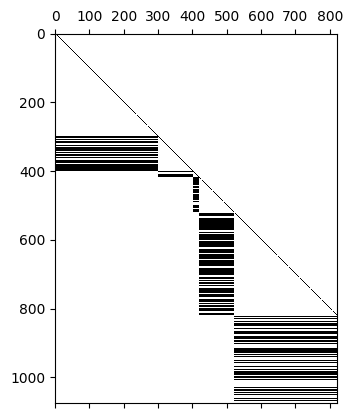

In [9]:
plt.spy(J)

Random-initialized model reconstruction results:


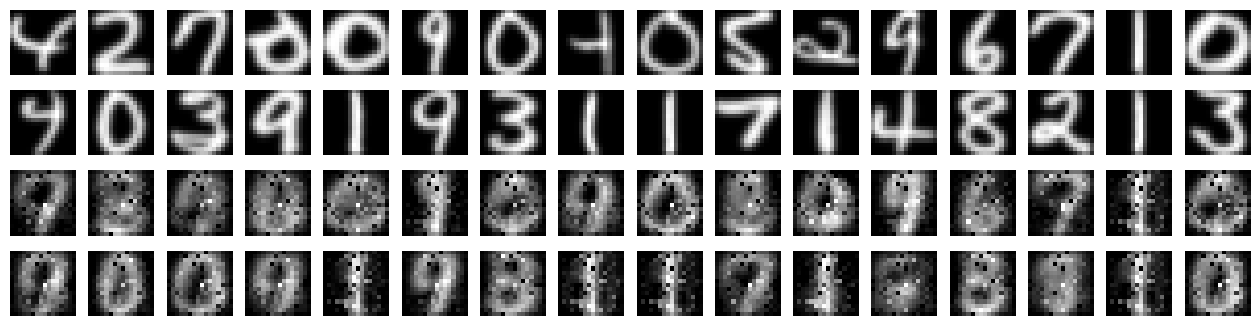

In [10]:
for x, _ in train_loader:
    x = x[32:64].to(device)
    with torch.no_grad():
        z = model(x)
    
    print('Random-initialized model reconstruction results:')
    plot_progress(x, z)
    
    break

In [55]:
%%time

relu = nn.ReLU()
line_search_c = pow(10,-4)
# backtracking multiplier
line_search_tau = 0.5
alphas_w = []
alphas_z = []
loss_hist = []
mu = 1.0

# registering hooks to cache activations
model = AE().to(device)

WEIGHTS = [
    model.encoder[0].weight.detach().cpu(),
    model.encoder[2].weight.detach().cpu(),
    model.encoder[4].weight.detach().cpu(),
    model.decoder[0].weight.detach().cpu(),
    model.decoder[2].weight.detach().cpu(),
    model.decoder[4].weight.detach().cpu(),
]

# sum of all output shapes
H = 0
h_k = [0]
for W in WEIGHTS:
    H += W.shape[0]
    h_k.append(W.shape[0] + h_k[-1])
h_k = h_k[1:]

CACHE_OUTPUTS = {}
CACHE_RELUS = {}

def cache_relu_hook(idx, module, input, output):
    CACHE_RELUS[idx] = output.detach().cpu()

i = 0 
for m in model.modules():
    if isinstance(m, nn.ReLU):
        handle = m.register_forward_hook(partial(cache_relu_hook, i))
        i += 1
        
# caching activations
with torch.no_grad():
    for x, _ in train_loader:
        x = x.to(device)
        _ = model(x)
        x = x.cpu()
        
        
with torch.no_grad():
    for epoch in range(10):
        
        # W-Step
        WEIGHTS_COPY = copy.deepcopy(WEIGHTS)

        for layer_idx in tqdm(range(len(CACHE_RELUS))):
            in_dim = WEIGHTS[layer_idx].shape[1]
            out_dim = WEIGHTS[layer_idx].shape[0]
            n_samples = CACHE_RELUS[layer_idx].shape[0]

            if layer_idx == 0:
                residuals = CACHE_RELUS[layer_idx] - relu(x @ WEIGHTS[layer_idx].T)
            elif layer_idx == len(CACHE_RELUS) - 1:
                # reconstruction task
                residuals = x - relu(CACHE_RELUS[layer_idx-1] @ WEIGHTS[layer_idx].T)
            else:
                residuals = CACHE_RELUS[layer_idx] - relu(CACHE_RELUS[layer_idx-1] @ WEIGHTS[layer_idx].T)
            # print('residuals:', residuals.shape)

            for h in range(out_dim):
                # Building Jacobian (for each layer and output dim)
                J = torch.zeros((n_samples, in_dim))
                w = WEIGHTS[layer_idx][h]

                if layer_idx == 0:
                    for n in range(n_samples):
                        if CACHE_RELUS[layer_idx][n][h] > 0:
                            J[n, :] = - x[n]
                else:
                    for n in range(n_samples):
                        if CACHE_RELUS[layer_idx][n][h] > 0:
                            J[n, :] = - CACHE_RELUS[layer_idx-1][n]

                p = torch.linalg.lstsq(J.T@J, - J.T @ residuals[:, h])[0]
                # print('shape of p:', p.shape, 'shape of w:', w.shape)
                # p.T @ grad (.T doesn't matter, numpy performs inner product)
                descent_inner_prod = (J.T @ residuals[:, h]) @ p
                try:
                    assert descent_inner_prod <= 0
                except:
                    pass
                    # print(f'layer {layer_idx+1} dim {h} descent(should be <= 0)', descent_inner_prod)

                # Line Search with Backtracking
                alpha = 1.0
                fw = (residuals[:,h]**2).sum() / 2
                # First Update
                w += alpha*p
                if layer_idx == 0:
                    residuals_new = CACHE_RELUS[layer_idx][:,h] - relu(torch.einsum('bq,q->b', x, w))
                elif layer_idx == len(CACHE_RELUS) - 1:
                    residuals_new = x[:,h] - relu(torch.einsum('bq,q->b', CACHE_RELUS[layer_idx-1], w))
                else:
                    residuals_new = CACHE_RELUS[layer_idx][:,h] - relu(torch.einsum('bq,q->b', CACHE_RELUS[layer_idx-1], w))
                fw_new = (residuals_new**2).sum() / 2
                rhs = alpha * line_search_c * descent_inner_prod

                max_iter, counter = 40, 0
                # Armijo Condition
                while fw_new - fw > rhs and counter < max_iter:
                    alpha *= line_search_tau
                    # Update
                    w = WEIGHTS_COPY[layer_idx][h] + alpha * p
                    if layer_idx == 0:
                        residuals_new = CACHE_RELUS[layer_idx][:,h] - relu(torch.einsum('bq,q->b', x, w))
                    else:
                        residuals_new = CACHE_RELUS[layer_idx][:,h] - relu(torch.einsum('bq,q->b', CACHE_RELUS[layer_idx-1], w))
                    fw_new = (residuals_new**2).sum() / 2
                    rhs = alpha * line_search_c * descent_inner_prod

                    # print("Line search armijo: obj func old: %f new: %f diff: %.16f rhs: %.16f, alpha: %f" % (fw, fw_new, fw_new - fw, rhs, alpha))
                    counter += 1
                # alphas_w.append(alpha)

        for layer_idx in range(len(CACHE_RELUS)):
            print(f'Layer {layer_idx}, '
                  f'Weights Diff Norm: {torch.linalg.norm(WEIGHTS[layer_idx]-WEIGHTS_COPY[layer_idx]) / torch.linalg.norm(WEIGHTS_COPY[layer_idx])}')
        model.encoder[0].weight.data = WEIGHTS[0]
        model.encoder[2].weight.data = WEIGHTS[1]
        model.encoder[4].weight.data = WEIGHTS[2]
        model.decoder[0].weight.data = WEIGHTS[3]
        model.decoder[2].weight.data = WEIGHTS[4]
        model.decoder[4].weight.data = WEIGHTS[5]
        model = model.to(device)
        
        # Removing Hooks
        for m in model.modules():
            if isinstance(m, nn.ReLU):
                m._forward_hooks = OrderedDict()
        # Loss on eval dataset
        loss = eval_loss(model, test_loader, loss_function, device=device)
        loss_hist.append(loss)
        print(f'Epoch {epoch+1}, Eval loss: {loss}')
        # Putting hooks back
        i = 0 
        for m in model.modules():
            if isinstance(m, nn.ReLU):
                handle = m.register_forward_hook(partial(cache_relu_hook, i))
                i += 1
        
        # # recalculating activations after weights update
        # for x, _ in train_loader:
        #     x = x.to(device)
        #     _ = model(x)
        #     x = x.cpu()

        # Z-Step
        CACHE_RELUS_COPY = copy.deepcopy(CACHE_RELUS)
            
        for n_sample in tqdm(range(len(x))):

            # Calculating Residuals
            residuals = torch.zeros(H)
            start = 0
            for layer_idx in range(len(h_k)):
                if layer_idx == 0:
                    residuals[start:h_k[layer_idx]] = CACHE_RELUS[layer_idx][n_sample] - relu(torch.einsum('q,hq->h', x[n_sample], WEIGHTS[layer_idx]))
                elif layer_idx == len(CACHE_RELUS) - 1:
                    residuals[start:h_k[layer_idx]] = x[n_sample] - relu(torch.einsum('q,hq->h', CACHE_RELUS[layer_idx-1][n_sample], WEIGHTS[layer_idx]))
                else:
                    residuals[start:h_k[layer_idx]] = CACHE_RELUS[layer_idx][n_sample] - relu(torch.einsum('q,hq->h', CACHE_RELUS[layer_idx-1][n_sample], WEIGHTS[layer_idx]))
                start = h_k[layer_idx]
            # Quadratic Penalty
            mu_mult = torch.ones_like(residuals)
            mu_mult[:h_k[-2]] = math.sqrt(mu)
            residuals = mu_mult * residuals

            # Building Jacobian for each sample in dataset
            J = torch.zeros((H, H))
            for h in range(H):
                if h < h_k[-2]: J[h, h] = 1
                for layer_idx in range(len(h_k)):
                    if h <= h_k[layer_idx]: break
                if layer_idx == 0: continue

                n_feature = h-h_k[layer_idx-1]-1
                assert n_feature >= 0 and n_feature < WEIGHTS[layer_idx].shape[0]

                if layer_idx == 1:
                    start, finish = 0, h_k[layer_idx-1]
                elif layer_idx > 1:
                    start, finish = h_k[layer_idx-2], h_k[layer_idx-1]
                # print(CACHE_RELUS[layer_idx][n_sample][n_feature])
                if CACHE_RELUS[layer_idx][n_sample][n_feature] > 0:
                    # print(start, finish, n_feature, WEIGHTS[layer_idx][n_feature].shape)
                    J[h, start:finish] = - WEIGHTS[layer_idx][n_feature]
                    # Quadratic Penalty
                    if layer_idx != len(CACHE_RELUS)-1:
                        J[h, start:finish] *= mu

            # Descent Direction
            p = torch.linalg.lstsq(J.T@J, - J.T @ residuals)[0]
            # print('shape of p:', p.shape, 'shape of w:', w.shape)
            # p.T @ grad (.T doesn't matter, numpy performs inner product)
            descent_inner_prod = (J.T @ residuals) @ p
            try:
                assert descent_inner_prod <= 0
            except:
                print(f'sample {n_sample} descent direction should be <= 0', descent_inner_prod)

            # Line Search with Backtracking
            alpha = 1.0
            fw = residuals.sum() / 2
            # update
            for layer_idx in range(len(CACHE_RELUS)):
                if layer_idx == 0:
                    start, finish = 0, h_k[layer_idx]
                else:
                    start, finish = h_k[layer_idx-1], h_k[layer_idx]

                CACHE_RELUS[layer_idx][n_sample] = CACHE_RELUS_COPY[layer_idx][n_sample] + alpha * p[start:finish]
                
            residuals_new = torch.zeros(H)
            start = 0
            for layer_idx in range(len(h_k)):
                if layer_idx == 0:
                    residuals_new[start:h_k[layer_idx]] = CACHE_RELUS[layer_idx][n_sample] - relu(torch.einsum('q,hq->h', x[n_sample], WEIGHTS[layer_idx]))
                elif layer_idx == len(CACHE_RELUS) - 1:
                    residuals_new[start:h_k[layer_idx]] = x[n_sample] - relu(torch.einsum('q,hq->h', CACHE_RELUS[layer_idx-1][n_sample], WEIGHTS[layer_idx]))
                else:
                    residuals_new[start:h_k[layer_idx]] = CACHE_RELUS[layer_idx][n_sample] - relu(torch.einsum('q,hq->h', CACHE_RELUS[layer_idx-1][n_sample], WEIGHTS[layer_idx]))
                start = h_k[layer_idx]
            # Quadratic Penalty
            residuals_new = mu_mult * residuals_new
            fw_new = (residuals_new**2).sum() / 2
            rhs = alpha * line_search_c * descent_inner_prod
            # print('fw:', fw, fw_new, rhs)
            

            max_iter, counter = 40, 0
            # Armijo Condition
            while fw_new - fw > rhs and counter < max_iter:
                # step update
                alpha *= line_search_tau
                
                # relus update
                for layer_idx in range(len(CACHE_RELUS)):
                    if layer_idx == 0:
                        start, finish = 0, h_k[layer_idx]
                    else:
                        start, finish = h_k[layer_idx-1], h_k[layer_idx]

                    CACHE_RELUS[layer_idx][n_sample] = CACHE_RELUS_COPY[layer_idx][n_sample] + alpha * p[start:finish]
                    
                # recompute residuals
                start = 0
                for layer_idx in range(len(h_k)):
                    if layer_idx == 0:
                        residuals_new[start:h_k[layer_idx]] = CACHE_RELUS[layer_idx][n_sample] - relu(torch.einsum('q,hq->h', x[n_sample], WEIGHTS[layer_idx]))
                    elif layer_idx == len(CACHE_RELUS) - 1:
                        residuals_new[start:h_k[layer_idx]] = x[n_sample] - relu(torch.einsum('q,hq->h', CACHE_RELUS[layer_idx-1][n_sample], WEIGHTS[layer_idx]))
                    else:
                        residuals_new[start:h_k[layer_idx]] = CACHE_RELUS[layer_idx][n_sample] - relu(torch.einsum('q,hq->h', CACHE_RELUS[layer_idx-1][n_sample], WEIGHTS[layer_idx]))
                    start = h_k[layer_idx]
                # Quadratic Penalty
                residuals_new = mu_mult * residuals_new
                fw_new = (residuals_new**2).sum() / 2
                rhs = alpha * line_search_c * descent_inner_prod

                # print("Line search armijo: obj func old: %f new: %f diff: %.16f rhs: %.16f, alpha: %f" % (fw, fw_new, fw_new - fw, rhs, alpha))
                counter += 1
        
        for layer_idx in range(len(CACHE_RELUS)):
            print(f'Layer {layer_idx} Activations Diff Norm: '
                  f'{torch.linalg.norm(CACHE_RELUS[layer_idx]-CACHE_RELUS_COPY[layer_idx]) / torch.linalg.norm(CACHE_RELUS_COPY[layer_idx])}')
            
        mu *= 4

        # print()

100%|██████████| 6/6 [01:56<00:00, 19.37s/it]

Layer 0, Weights Diff Norm: 9.252866584574804e-05
Layer 1, Weights Diff Norm: 8.079350664047524e-05
Layer 2, Weights Diff Norm: 0.0001753252581693232
Layer 3, Weights Diff Norm: 0.0003796993405558169
Layer 4, Weights Diff Norm: 0.00022098592307884246
Layer 5, Weights Diff Norm: 53.81589889526367


Epoch 1, Eval loss: 0.06152551621198654


100%|██████████| 7291/7291 [09:00<00:00, 13.50it/s]


Layer 0 Activations Diff Norm: 0.0
Layer 1 Activations Diff Norm: 0.0
Layer 2 Activations Diff Norm: 0.0
Layer 3 Activations Diff Norm: 0.0
Layer 4 Activations Diff Norm: 0.0
Layer 5 Activations Diff Norm: 0.0


100%|██████████| 6/6 [02:04<00:00, 20.71s/it]

Layer 0, Weights Diff Norm: 9.483759640716016e-06
Layer 1, Weights Diff Norm: 1.705144859442953e-05
Layer 2, Weights Diff Norm: 6.40711878077127e-05
Layer 3, Weights Diff Norm: 3.926243516616523e-05
Layer 4, Weights Diff Norm: 0.00011110241030110046
Layer 5, Weights Diff Norm: 0.21595144271850586


Epoch 2, Eval loss: 0.0618380606174469


100%|██████████| 7291/7291 [10:02<00:00, 12.10it/s]


Layer 0 Activations Diff Norm: 0.0
Layer 1 Activations Diff Norm: 0.0
Layer 2 Activations Diff Norm: 0.0
Layer 3 Activations Diff Norm: 0.0
Layer 4 Activations Diff Norm: 0.0
Layer 5 Activations Diff Norm: 0.0


100%|██████████| 6/6 [02:05<00:00, 20.85s/it]

Layer 0, Weights Diff Norm: 5.502930889633717e-06
Layer 1, Weights Diff Norm: 8.199510375561658e-06
Layer 2, Weights Diff Norm: 4.86737881146837e-05
Layer 3, Weights Diff Norm: 1.4566425306838937e-05
Layer 4, Weights Diff Norm: 0.0001587014994584024
Layer 5, Weights Diff Norm: 0.17921271920204163


Epoch 3, Eval loss: 0.061798013746738434


100%|██████████| 7291/7291 [10:48<00:00, 11.24it/s]


Layer 0 Activations Diff Norm: 0.0
Layer 1 Activations Diff Norm: 0.0
Layer 2 Activations Diff Norm: 0.0
Layer 3 Activations Diff Norm: 0.0
Layer 4 Activations Diff Norm: 0.0
Layer 5 Activations Diff Norm: 0.0


100%|██████████| 6/6 [02:05<00:00, 20.89s/it]

Layer 0, Weights Diff Norm: 2.906140025515924e-06
Layer 1, Weights Diff Norm: 5.2913201216142625e-06
Layer 2, Weights Diff Norm: 2.1502573872567154e-05
Layer 3, Weights Diff Norm: 0.00023309444077312946
Layer 4, Weights Diff Norm: 0.00013369151565711945
Layer 5, Weights Diff Norm: 0.14721262454986572


Epoch 4, Eval loss: 0.06213661655783653


100%|██████████| 7291/7291 [11:15<00:00, 10.80it/s]


Layer 0 Activations Diff Norm: 0.0
Layer 1 Activations Diff Norm: 0.0
Layer 2 Activations Diff Norm: 0.0
Layer 3 Activations Diff Norm: 0.0
Layer 4 Activations Diff Norm: 0.0
Layer 5 Activations Diff Norm: 0.0


100%|██████████| 6/6 [02:05<00:00, 20.98s/it]

Layer 0, Weights Diff Norm: 1.6730472225390258e-06
Layer 1, Weights Diff Norm: 4.2177903196716215e-06
Layer 2, Weights Diff Norm: 2.899955870816484e-05
Layer 3, Weights Diff Norm: 5.9269001212669536e-05
Layer 4, Weights Diff Norm: 7.168505544541404e-05
Layer 5, Weights Diff Norm: 0.07925637811422348


Epoch 5, Eval loss: 0.06229625642299652


100%|██████████| 7291/7291 [07:50<00:00, 15.49it/s]


Layer 0 Activations Diff Norm: 0.0
Layer 1 Activations Diff Norm: 0.0
Layer 2 Activations Diff Norm: 0.0
Layer 3 Activations Diff Norm: 0.0
Layer 4 Activations Diff Norm: 0.0
Layer 5 Activations Diff Norm: 0.0


100%|██████████| 6/6 [02:05<00:00, 20.95s/it]

Layer 0, Weights Diff Norm: 3.632222615124192e-06
Layer 1, Weights Diff Norm: 3.219540531063103e-06
Layer 2, Weights Diff Norm: 1.6122861779876985e-05
Layer 3, Weights Diff Norm: 3.613807564306626e-08
Layer 4, Weights Diff Norm: 9.381707786815241e-05
Layer 5, Weights Diff Norm: 0.11037002503871918


Epoch 6, Eval loss: 0.062200043350458145


  0%|          | 0/7291 [00:00<?, ?it/s]


Intel MKL ERROR: Parameter 4 was incorrect on entry to SGELSY.


RuntimeError: falseINTERNAL ASSERT FAILED at "../aten/src/ATen/native/LinearAlgebraUtils.h":328, please report a bug to PyTorch. torch.linalg.lstsq: Argument 4 has illegal value. Most certainly there is a bug in the implementation calling the backend library.

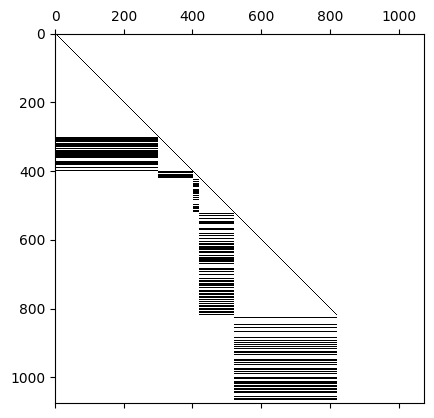

In [56]:
# Jacobian for Z-step
plt.spy(J)
plt.show()

Trained model reconstruction results:


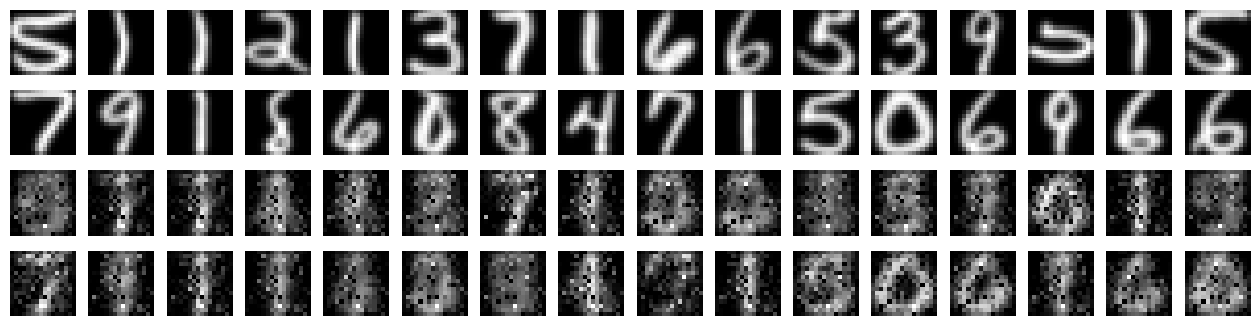

In [57]:
for x, _ in train_loader:
    x = x[:32].to(device)
    with torch.no_grad():
        z = model(x)
    
    print('Trained model reconstruction results:')
    plot_progress(x, z)
    
    break

In [58]:
print(f'Eval loss: {eval_loss(model, test_loader, loss_function, device=device)}')

Eval loss: 0.062200043350458145


In [51]:
%%time

relu = nn.ReLU()
line_search_c = pow(10,-4)
# backtracking multiplier
line_search_tau = 0.5
alphas_w = []
alphas_z = []
loss_hist = []

# registering hooks to cache activations
model = AE().to(device)

WEIGHTS = [
    model.encoder[0].weight.detach().cpu(),
    model.encoder[2].weight.detach().cpu(),
    model.encoder[4].weight.detach().cpu(),
    model.decoder[0].weight.detach().cpu(),
    model.decoder[2].weight.detach().cpu(),
    model.decoder[4].weight.detach().cpu(),
]

# sum of all output shapes
H = 0
h_k = [0]
for W in WEIGHTS:
    H += W.shape[0]
    h_k.append(W.shape[0] + h_k[-1])
h_k = h_k[1:]

CACHE_OUTPUTS = {}
CACHE_RELUS = {}

def cache_relu_hook(idx, module, input, output):
    CACHE_RELUS[idx] = output.detach().cpu()

i = 0 
for m in model.modules():
    if isinstance(m, nn.ReLU):
        handle = m.register_forward_hook(partial(cache_relu_hook, i))
        i += 1
        
# caching activations
with torch.no_grad():
    for x, _ in train_loader:
        x = x.to(device)
        _ = model(x)
        x = x.cpu()
        
        
with torch.no_grad():
    for epoch in range(10):
        
        # W-Step
        WEIGHTS_COPY = copy.deepcopy(WEIGHTS)

        for layer_idx in tqdm(range(len(CACHE_RELUS))):
            in_dim = WEIGHTS[layer_idx].shape[1]
            out_dim = WEIGHTS[layer_idx].shape[0]
            n_samples = CACHE_RELUS[layer_idx].shape[0]

            if layer_idx == 0:
                residuals = CACHE_RELUS[layer_idx] - relu(x @ WEIGHTS[layer_idx].T)
            elif layer_idx == len(CACHE_RELUS) - 1:
                # reconstruction task
                residuals = x - relu(CACHE_RELUS[layer_idx-1] @ WEIGHTS[layer_idx].T)
            else:
                residuals = CACHE_RELUS[layer_idx] - relu(CACHE_RELUS[layer_idx-1] @ WEIGHTS[layer_idx].T)
            # print('residuals:', residuals.shape)

            for h in range(out_dim):
                # Building Jacobian (for each layer and output dim)
                J = torch.zeros((n_samples, in_dim))
                w = WEIGHTS[layer_idx][h]

                if layer_idx == 0:
                    for n in range(n_samples):
                        if CACHE_RELUS[layer_idx][n][h] > 0:
                            J[n, :] = - x[n]
                else:
                    for n in range(n_samples):
                        if CACHE_RELUS[layer_idx][n][h] > 0:
                            J[n, :] = - CACHE_RELUS[layer_idx-1][n]

                p = torch.linalg.lstsq(J.T@J, - J.T @ residuals[:, h])[0]
                # print('shape of p:', p.shape, 'shape of w:', w.shape)
                # p.T @ grad (.T doesn't matter, numpy performs inner product)
                descent_inner_prod = (J.T @ residuals[:, h]) @ p
                try:
                    assert descent_inner_prod <= 0
                except:
                    pass
                    # print(f'layer {layer_idx+1} dim {h} descent(should be <= 0)', descent_inner_prod)

                # Line Search with Backtracking
                alpha = 1.0
                fw = (residuals[:,h]**2).sum() / 2
                # First Update
                w += alpha*p
                if layer_idx == 0:
                    residuals_new = CACHE_RELUS[layer_idx][:,h] - relu(torch.einsum('bq,q->b', x, w))
                elif layer_idx == len(CACHE_RELUS) - 1:
                    residuals_new = x[:,h] - relu(torch.einsum('bq,q->b', CACHE_RELUS[layer_idx-1], w))
                else:
                    residuals_new = CACHE_RELUS[layer_idx][:,h] - relu(torch.einsum('bq,q->b', CACHE_RELUS[layer_idx-1], w))
                fw_new = (residuals_new**2).sum() / 2
                rhs = alpha * line_search_c * descent_inner_prod

                max_iter, counter = 40, 0
                # Armijo Condition
                while fw_new - fw > rhs and counter < max_iter:
                    alpha *= line_search_tau
                    # Update
                    w = WEIGHTS_COPY[layer_idx][h] + alpha * p
                    if layer_idx == 0:
                        residuals_new = CACHE_RELUS[layer_idx][:,h] - relu(torch.einsum('bq,q->b', x, w))
                    else:
                        residuals_new = CACHE_RELUS[layer_idx][:,h] - relu(torch.einsum('bq,q->b', CACHE_RELUS[layer_idx-1], w))
                    fw_new = (residuals_new**2).sum() / 2
                    rhs = alpha * line_search_c * descent_inner_prod

                    # print("Line search armijo: obj func old: %f new: %f diff: %.16f rhs: %.16f, alpha: %f" % (fw, fw_new, fw_new - fw, rhs, alpha))
                    counter += 1
                # alphas_w.append(alpha)

        for layer_idx in range(len(CACHE_RELUS)):
            print(f'Layer {layer_idx}, '
                  f'Weights Diff Norm: {torch.linalg.norm(WEIGHTS[layer_idx]-WEIGHTS_COPY[layer_idx]) / torch.linalg.norm(WEIGHTS_COPY[layer_idx])}')
        model.encoder[0].weight.data = WEIGHTS[0]
        model.encoder[2].weight.data = WEIGHTS[1]
        model.encoder[4].weight.data = WEIGHTS[2]
        model.decoder[0].weight.data = WEIGHTS[3]
        model.decoder[2].weight.data = WEIGHTS[4]
        model.decoder[4].weight.data = WEIGHTS[5]
        model = model.to(device)
        
        # Removing Hooks
        for m in model.modules():
            if isinstance(m, nn.ReLU):
                m._forward_hooks = OrderedDict()
        # Loss on eval dataset
        loss = eval_loss(model, test_loader, loss_function, device=device)
        loss_hist.append(loss)
        print(f'Epoch {epoch+1}, Eval loss: {loss}')
        # Putting hooks back
        i = 0 
        for m in model.modules():
            if isinstance(m, nn.ReLU):
                handle = m.register_forward_hook(partial(cache_relu_hook, i))
                i += 1
        
        # recalculating activations after weights update
        for x, _ in train_loader:
            x = x.to(device)
            _ = model(x)
            x = x.cpu()

        # Z-Step
        CACHE_RELUS_COPY = copy.deepcopy(CACHE_RELUS)
            
        for n_sample in tqdm(range(len(x))):

            # Calculating Residuals
            residuals = torch.zeros(H)
            start = 0
            for layer_idx in range(len(h_k)):
                if layer_idx == 0:
                    residuals[start:h_k[layer_idx]] = CACHE_RELUS[layer_idx][n_sample] - relu(torch.einsum('q,hq->h', x[n_sample], WEIGHTS[layer_idx]))
                elif layer_idx == len(CACHE_RELUS) - 1:
                    residuals[start:h_k[layer_idx]] = x[n_sample] - relu(torch.einsum('q,hq->h', CACHE_RELUS[layer_idx-1][n_sample], WEIGHTS[layer_idx]))
                else:
                    residuals[start:h_k[layer_idx]] = CACHE_RELUS[layer_idx][n_sample] - relu(torch.einsum('q,hq->h', CACHE_RELUS[layer_idx-1][n_sample], WEIGHTS[layer_idx]))
                start = h_k[layer_idx]
            # Quadratic Penalty
            mu_mult = torch.ones_like(residuals)
            mu_mult[:h_k[-2]] = math.sqrt(mu)
            residuals = mu_mult * residuals

            # Building Jacobian for each sample in dataset
            J = torch.zeros((H, H))
            for h in range(H):
                if h < h_k[-2]: J[h, h] = 1
                for layer_idx in range(len(h_k)):
                    if h <= h_k[layer_idx]: break
                if layer_idx == 0: continue

                n_feature = h-h_k[layer_idx-1]-1
                assert n_feature >= 0 and n_feature < WEIGHTS[layer_idx].shape[0]

                if layer_idx == 1:
                    start, finish = 0, h_k[layer_idx-1]
                elif layer_idx > 1:
                    start, finish = h_k[layer_idx-2], h_k[layer_idx-1]
                # print(CACHE_RELUS[layer_idx][n_sample][n_feature])
                if CACHE_RELUS[layer_idx][n_sample][n_feature] > 0:
                    # print(start, finish, n_feature, WEIGHTS[layer_idx][n_feature].shape)
                    J[h, start:finish] = - WEIGHTS[layer_idx][n_feature]
                    # Quadratic Penalty
                    if layer_idx != len(CACHE_RELUS)-1:
                        J[h, start:finish] *= mu

            # Descent Direction
            p = torch.linalg.lstsq(J.T@J, - J.T @ residuals)[0]
            # print('shape of p:', p.shape, 'shape of w:', w.shape)
            # p.T @ grad (.T doesn't matter, numpy performs inner product)
            descent_inner_prod = (J.T @ residuals) @ p
            try:
                assert descent_inner_prod <= 0
            except:
                print(f'sample {n_sample} descent direction should be <= 0', descent_inner_prod)

            # Line Search with Backtracking
            alpha = 1.0
            fw = residuals.sum() / 2
            # update
            for layer_idx in range(len(CACHE_RELUS)):
                if layer_idx == 0:
                    start, finish = 0, h_k[layer_idx]
                else:
                    start, finish = h_k[layer_idx-1], h_k[layer_idx]

                CACHE_RELUS[layer_idx][n_sample] = CACHE_RELUS_COPY[layer_idx][n_sample] + alpha * p[start:finish]
                
            residuals_new = torch.zeros(H)
            start = 0
            for layer_idx in range(len(h_k)):
                if layer_idx == 0:
                    residuals_new[start:h_k[layer_idx]] = CACHE_RELUS[layer_idx][n_sample] - relu(torch.einsum('q,hq->h', x[n_sample], WEIGHTS[layer_idx]))
                elif layer_idx == len(CACHE_RELUS) - 1:
                    residuals_new[start:h_k[layer_idx]] = x[n_sample] - relu(torch.einsum('q,hq->h', CACHE_RELUS[layer_idx-1][n_sample], WEIGHTS[layer_idx]))
                else:
                    residuals_new[start:h_k[layer_idx]] = CACHE_RELUS[layer_idx][n_sample] - relu(torch.einsum('q,hq->h', CACHE_RELUS[layer_idx-1][n_sample], WEIGHTS[layer_idx]))
                start = h_k[layer_idx]
            # Quadratic Penalty
            residuals_new = mu_mult * residuals_new
            fw_new = (residuals_new**2).sum() / 2
            rhs = alpha * line_search_c * descent_inner_prod
            # print('fw:', fw, fw_new, rhs)
            

            max_iter, counter = 40, 0
            # Armijo Condition
            while fw_new - fw > rhs and counter < max_iter:
                # step update
                alpha *= line_search_tau
                
                # relus update
                for layer_idx in range(len(CACHE_RELUS)):
                    if layer_idx == 0:
                        start, finish = 0, h_k[layer_idx]
                    else:
                        start, finish = h_k[layer_idx-1], h_k[layer_idx]

                    CACHE_RELUS[layer_idx][n_sample] = CACHE_RELUS_COPY[layer_idx][n_sample] + alpha * p[start:finish]
                    
                # recompute residuals
                start = 0
                for layer_idx in range(len(h_k)):
                    if layer_idx == 0:
                        residuals_new[start:h_k[layer_idx]] = CACHE_RELUS[layer_idx][n_sample] - relu(torch.einsum('q,hq->h', x[n_sample], WEIGHTS[layer_idx]))
                    elif layer_idx == len(CACHE_RELUS) - 1:
                        residuals_new[start:h_k[layer_idx]] = x[n_sample] - relu(torch.einsum('q,hq->h', CACHE_RELUS[layer_idx-1][n_sample], WEIGHTS[layer_idx]))
                    else:
                        residuals_new[start:h_k[layer_idx]] = CACHE_RELUS[layer_idx][n_sample] - relu(torch.einsum('q,hq->h', CACHE_RELUS[layer_idx-1][n_sample], WEIGHTS[layer_idx]))
                    start = h_k[layer_idx]
                # Quadratic Penalty
                residuals_new = mu_mult * residuals_new
                fw_new = (residuals_new**2).sum() / 2
                rhs = alpha * line_search_c * descent_inner_prod

                # print("Line search armijo: obj func old: %f new: %f diff: %.16f rhs: %.16f, alpha: %f" % (fw, fw_new, fw_new - fw, rhs, alpha))
                counter += 1
        
        for layer_idx in range(len(CACHE_RELUS)):
            print(f'Layer {layer_idx} Activations Diff Norm: '
                  f'{torch.linalg.norm(CACHE_RELUS[layer_idx]-CACHE_RELUS_COPY[layer_idx]) / torch.linalg.norm(CACHE_RELUS_COPY[layer_idx])}')
            
        mu *= 4

        # print()

100%|██████████| 6/6 [01:54<00:00, 19.09s/it]

Layer 0, Weights Diff Norm: 7.568952423753217e-05
Layer 1, Weights Diff Norm: 7.839558384148404e-05
Layer 2, Weights Diff Norm: 0.00022436623112298548
Layer 3, Weights Diff Norm: 0.0004299689317122102
Layer 4, Weights Diff Norm: 4.5003755076322705e-05
Layer 5, Weights Diff Norm: 12.003912925720215


Epoch 1, Eval loss: 0.08763116598129272


100%|██████████| 7291/7291 [08:27<00:00, 14.35it/s]


Layer 0 Activations Diff Norm: 1.0414826922831126e-22
Layer 1 Activations Diff Norm: 0.0
Layer 2 Activations Diff Norm: 0.0
Layer 3 Activations Diff Norm: 0.0
Layer 4 Activations Diff Norm: 0.0
Layer 5 Activations Diff Norm: 0.0


100%|██████████| 6/6 [02:16<00:00, 22.77s/it]

Layer 0, Weights Diff Norm: 2.988283449667506e-05
Layer 1, Weights Diff Norm: 4.108197026653215e-05
Layer 2, Weights Diff Norm: 7.895260205259547e-05
Layer 3, Weights Diff Norm: 0.000332422845531255
Layer 4, Weights Diff Norm: 2.7074143872596323e-05
Layer 5, Weights Diff Norm: 1.4477218389511108


Epoch 2, Eval loss: 0.0752287358045578


100%|██████████| 7291/7291 [08:28<00:00, 14.34it/s]


Layer 0 Activations Diff Norm: 3.147341388298703e-23
Layer 1 Activations Diff Norm: 0.0
Layer 2 Activations Diff Norm: 0.0
Layer 3 Activations Diff Norm: 0.0
Layer 4 Activations Diff Norm: 0.0
Layer 5 Activations Diff Norm: 0.0


100%|██████████| 6/6 [02:09<00:00, 21.59s/it]

Layer 0, Weights Diff Norm: 2.4067305275821127e-05
Layer 1, Weights Diff Norm: 3.3578591683181e-05
Layer 2, Weights Diff Norm: 6.852474325569347e-05
Layer 3, Weights Diff Norm: 0.0010224052239209414
Layer 4, Weights Diff Norm: 2.5172186724375933e-05
Layer 5, Weights Diff Norm: 0.09272044152021408


Epoch 3, Eval loss: 0.06842724978923798


100%|██████████| 7291/7291 [08:42<00:00, 13.95it/s]


Layer 0 Activations Diff Norm: 3.0424381129197794e-24
Layer 1 Activations Diff Norm: 0.0
Layer 2 Activations Diff Norm: 0.0
Layer 3 Activations Diff Norm: 0.0
Layer 4 Activations Diff Norm: 0.0
Layer 5 Activations Diff Norm: 0.0


100%|██████████| 6/6 [02:10<00:00, 21.72s/it]

Layer 0, Weights Diff Norm: 2.0665169358835556e-05
Layer 1, Weights Diff Norm: 2.8643607947742566e-05
Layer 2, Weights Diff Norm: 7.214830111479387e-05
Layer 3, Weights Diff Norm: 0.0006283328402787447
Layer 4, Weights Diff Norm: 3.197519254172221e-05
Layer 5, Weights Diff Norm: 2.3097751140594482


Epoch 4, Eval loss: 0.06331782042980194


100%|██████████| 7291/7291 [08:52<00:00, 13.70it/s]


Layer 0 Activations Diff Norm: 0.0
Layer 1 Activations Diff Norm: 0.0
Layer 2 Activations Diff Norm: 0.0
Layer 3 Activations Diff Norm: 0.0
Layer 4 Activations Diff Norm: 0.0
Layer 5 Activations Diff Norm: 0.0


100%|██████████| 6/6 [02:09<00:00, 21.62s/it]

Layer 0, Weights Diff Norm: 1.767960020515602e-05
Layer 1, Weights Diff Norm: 2.6364026780356653e-05
Layer 2, Weights Diff Norm: 6.396291428245604e-05
Layer 3, Weights Diff Norm: 0.0008665069472044706
Layer 4, Weights Diff Norm: 2.1604104404104874e-05
Layer 5, Weights Diff Norm: 0.4806345999240875


Epoch 5, Eval loss: 0.06259052455425262


100%|██████████| 7291/7291 [08:56<00:00, 13.59it/s]


Layer 0 Activations Diff Norm: 0.0
Layer 1 Activations Diff Norm: 0.0
Layer 2 Activations Diff Norm: 0.0
Layer 3 Activations Diff Norm: 0.0
Layer 4 Activations Diff Norm: 0.0
Layer 5 Activations Diff Norm: 0.0


100%|██████████| 6/6 [02:09<00:00, 21.63s/it]

Layer 0, Weights Diff Norm: 1.4770761481486261e-05
Layer 1, Weights Diff Norm: 2.550770113884937e-05
Layer 2, Weights Diff Norm: 6.269845471251756e-05
Layer 3, Weights Diff Norm: 0.0006335765938274562
Layer 4, Weights Diff Norm: 2.050176408374682e-05
Layer 5, Weights Diff Norm: 0.24850249290466309


Epoch 6, Eval loss: 0.06255244463682175


100%|██████████| 7291/7291 [08:55<00:00, 13.61it/s]


Layer 0 Activations Diff Norm: 0.0
Layer 1 Activations Diff Norm: 0.0
Layer 2 Activations Diff Norm: 0.0
Layer 3 Activations Diff Norm: 0.0
Layer 4 Activations Diff Norm: 0.0
Layer 5 Activations Diff Norm: 0.0


100%|██████████| 6/6 [02:09<00:00, 21.51s/it]

Layer 0, Weights Diff Norm: 1.3451830454869196e-05
Layer 1, Weights Diff Norm: 2.2052401618566364e-05
Layer 2, Weights Diff Norm: 6.516986468341202e-05
Layer 3, Weights Diff Norm: 0.0005304958904162049
Layer 4, Weights Diff Norm: 1.6077656255220063e-05
Layer 5, Weights Diff Norm: 0.12255990505218506


Epoch 7, Eval loss: 0.06254546344280243


100%|██████████| 7291/7291 [08:51<00:00, 13.72it/s]


Layer 0 Activations Diff Norm: 0.0
Layer 1 Activations Diff Norm: 0.0
Layer 2 Activations Diff Norm: 0.0
Layer 3 Activations Diff Norm: 0.0
Layer 4 Activations Diff Norm: 0.0
Layer 5 Activations Diff Norm: 0.0


100%|██████████| 6/6 [02:09<00:00, 21.54s/it]

Layer 0, Weights Diff Norm: 1.1419416296121199e-05
Layer 1, Weights Diff Norm: 2.1679421479348093e-05
Layer 2, Weights Diff Norm: 4.738929055747576e-05
Layer 3, Weights Diff Norm: 0.0004967442946508527
Layer 4, Weights Diff Norm: 1.8424283553031273e-05
Layer 5, Weights Diff Norm: 0.0794801190495491


Epoch 8, Eval loss: 0.06254372000694275


100%|██████████| 7291/7291 [08:43<00:00, 13.92it/s]


Layer 0 Activations Diff Norm: 0.0
Layer 1 Activations Diff Norm: 0.0
Layer 2 Activations Diff Norm: 0.0
Layer 3 Activations Diff Norm: 0.0
Layer 4 Activations Diff Norm: 0.0
Layer 5 Activations Diff Norm: 0.0


100%|██████████| 6/6 [02:08<00:00, 21.49s/it]

Layer 0, Weights Diff Norm: 1.1817065569630358e-05
Layer 1, Weights Diff Norm: 2.2111114958534017e-05
Layer 2, Weights Diff Norm: 6.623224908253178e-05
Layer 3, Weights Diff Norm: 0.0004931375733576715
Layer 4, Weights Diff Norm: 1.66773097589612e-05
Layer 5, Weights Diff Norm: 0.008183520287275314


Epoch 9, Eval loss: 0.06254217028617859


100%|██████████| 7291/7291 [08:18<00:00, 14.62it/s]


Layer 0 Activations Diff Norm: 0.0
Layer 1 Activations Diff Norm: 0.0
Layer 2 Activations Diff Norm: 0.0
Layer 3 Activations Diff Norm: 0.0
Layer 4 Activations Diff Norm: 0.0
Layer 5 Activations Diff Norm: 0.0


100%|██████████| 6/6 [02:09<00:00, 21.53s/it]

Layer 0, Weights Diff Norm: 1.0128524081665091e-05
Layer 1, Weights Diff Norm: 1.8392011043033563e-05
Layer 2, Weights Diff Norm: 5.827877248520963e-05
Layer 3, Weights Diff Norm: 0.00063039775704965
Layer 4, Weights Diff Norm: 1.817988777474966e-05
Layer 5, Weights Diff Norm: 0.14669473469257355


Epoch 10, Eval loss: 0.062468271702528


100%|██████████| 7291/7291 [08:24<00:00, 14.44it/s]

Layer 0 Activations Diff Norm: 0.0
Layer 1 Activations Diff Norm: 0.0
Layer 2 Activations Diff Norm: 0.0
Layer 3 Activations Diff Norm: 0.0
Layer 4 Activations Diff Norm: 0.0
Layer 5 Activations Diff Norm: 0.0
CPU times: user 5h 12min 4s, sys: 29.4 s, total: 5h 12min 33s
Wall time: 1h 48min 36s


Trained model reconstruction results:


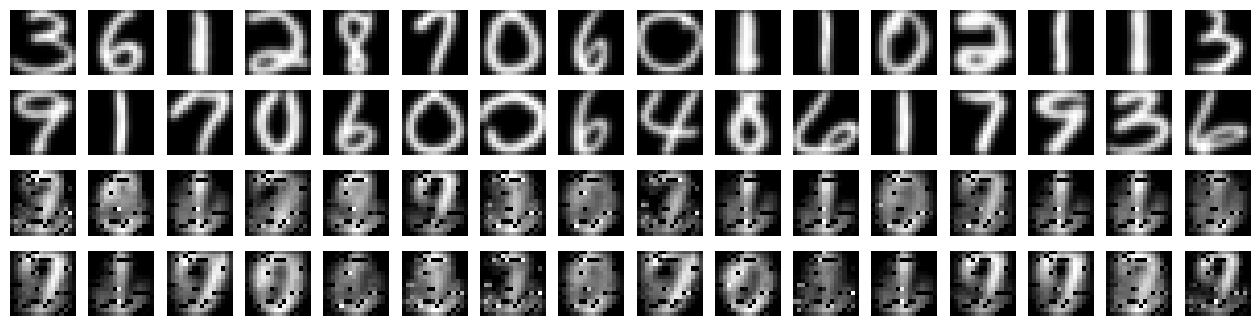

In [52]:
for x, _ in train_loader:
    x = x[:32].to(device)
    with torch.no_grad():
        z = model(x)
    
    print('Trained model reconstruction results:')
    plot_progress(x, z)
    
    break

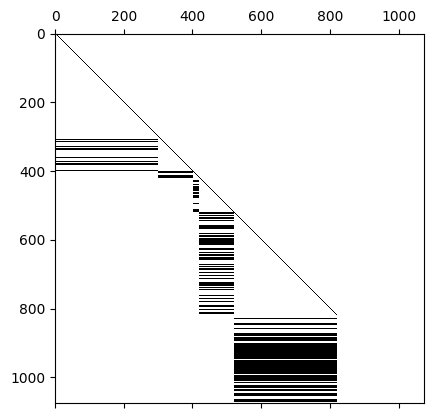

In [54]:
# Jacobian for Z-step
plt.spy(J)
plt.show()

## cpu, numpy, pool+map

In [5]:
device = 'cpu'

In [6]:
def relu(x):
    return np.maximum(0.0, x)

def calculate_z_residuals(cache_relus, x, h_k, WEIGHTS):
    
    residuals = np.zeros(h_k[-1])
    start = 0
    for layer_idx in range(len(h_k)):
        if layer_idx == 0:
            residuals[start:h_k[layer_idx]] = cache_relus[start:h_k[layer_idx]] - relu(np.einsum('q,hq->h', x, WEIGHTS[layer_idx]))
        elif layer_idx == 1:
            residuals[start:h_k[layer_idx]] = cache_relus[start:h_k[layer_idx]] \
                                              - relu(np.einsum('q,hq->h', cache_relus[:h_k[layer_idx-1]], 
                                                                             WEIGHTS[layer_idx]))
        elif layer_idx == len(h_k) - 1:
            residuals[start:h_k[layer_idx]] = x - relu(np.einsum('q,hq->h', cache_relus[h_k[layer_idx-2]:h_k[layer_idx-1]], WEIGHTS[layer_idx]))
        else:
            residuals[start:h_k[layer_idx]] = cache_relus[start:h_k[layer_idx]] \
                                              - relu(np.einsum('q,hq->h', cache_relus[h_k[layer_idx-2]:h_k[layer_idx-1]], 
                                                                             WEIGHTS[layer_idx]))
        start = h_k[layer_idx]
    return residuals

def z_step(n_sample, cache_relus, x, WEIGHTS, mu, h_k):
    
    # Calculating Residuals
    residuals = calculate_z_residuals(cache_relus, x, h_k, WEIGHTS)
    
    # Quadratic Penalty
    mu_mult = np.ones_like(residuals)
    mu_mult[:h_k[-2]] = math.sqrt(mu)
    residuals = mu_mult * residuals

    # Building Jacobian for each sample in dataset
    J = np.zeros((h_k[-1], h_k[-2]))
    for h in range(h_k[-1]):
        if h < h_k[-2]: J[h, h] = mu
        for layer_idx in range(len(h_k)):
            if h < h_k[layer_idx]: break
        if layer_idx == 0: continue

        n_feature = h-h_k[layer_idx-1]
        assert n_feature >= 0 and n_feature < WEIGHTS[layer_idx].shape[0]

        if layer_idx == 1:
            start, finish = 0, h_k[layer_idx-1]
        elif layer_idx > 1:
            start, finish = h_k[layer_idx-2], h_k[layer_idx-1]
        if cache_relus[h] > 0:
            J[h, start:finish] = - WEIGHTS[layer_idx][n_feature]
            # Quadratic Penalty
            if layer_idx != len(h_k)-1:
                J[h, start:finish] *= mu

    # Descent Direction
    p = np.linalg.lstsq(J.T@J, - J.T @ residuals, rcond=None)[0]
    # p.T @ grad (.T doesn't matter, numpy performs inner product)
    descent_inner_prod = (J.T @ residuals) @ p
    try:
        assert descent_inner_prod <= 0
    except:
        print(f'sample {n_sample} descent direction should be <= 0', descent_inner_prod)

    # Line Search with Backtracking
    alpha = 1.0
    fw = residuals.sum() / 2
    # recompute residuals with relus update
    p_ = np.zeros(h_k[-1])
    p_[:h_k[-2]] = p
    residuals_new = calculate_z_residuals(cache_relus + alpha * p_, x, h_k, WEIGHTS)

    # Quadratic Penalty
    residuals_new = mu_mult * residuals_new
    fw_new = (residuals_new**2).sum() / 2
    rhs = alpha * line_search_c * descent_inner_prod

    max_iter, counter = 40, 0
    # Armijo Condition
    while fw_new - fw > rhs and counter < max_iter:
        # step update
        alpha *= line_search_tau

        # recompute residuals with new relus update
        residuals_new = calculate_z_residuals(cache_relus + alpha * p_, x, h_k, WEIGHTS)

        # Quadratic Penalty
        residuals_new = mu_mult * residuals_new
        fw_new = (residuals_new**2).sum() / 2
        rhs = alpha * line_search_c * descent_inner_prod

        # print("Line search armijo: obj func old: %f new: %f diff: %.16f rhs: %.16f, alpha: %f" % (fw, fw_new, fw_new - fw, rhs, alpha))
        counter += 1
        
    return (n_sample, cache_relus + alpha * p_)

In [7]:
def relu(x):
    return np.maximum(0.0, x)

def calculate_w_residuals(layer_idx, h, w_h, x, CACHE_RELUS):
    
    if layer_idx == 0:
        residuals = CACHE_RELUS[layer_idx][:,h] - relu(np.einsum('bq,q->b', x, w_h))
    elif layer_idx == len(CACHE_RELUS) - 1:
        residuals = x[:,h] - relu(np.einsum('bq,q->b', CACHE_RELUS[layer_idx-1], w_h))
    else:
        residuals = CACHE_RELUS[layer_idx][:,h] - relu(np.einsum('bq,q->b', CACHE_RELUS[layer_idx-1], w_h))
        
    return residuals

def w_step(layer_idx, h, w_h, x, CACHE_RELUS, n_samples):
    
    residuals = calculate_w_residuals(layer_idx, h, w_h, x, CACHE_RELUS)
    
    # Building Jacobian (for each layer and output dim)
    J = np.zeros((n_samples, len(w_h)))

    if layer_idx == 0:
        for n in range(n_samples):
            if CACHE_RELUS[layer_idx][n][h] > 0:
                J[n, :] = - x[n]
    else:
        for n in range(n_samples):
            if CACHE_RELUS[layer_idx][n][h] > 0:
                J[n, :] = - CACHE_RELUS[layer_idx-1][n]

    p = np.linalg.lstsq(J.T@J, - J.T @ residuals, rcond=None)[0]
    # p.T @ grad (.T doesn't matter, numpy performs inner product)
    descent_inner_prod = (J.T @ residuals) @ p
    try:
        assert descent_inner_prod <= 0
    except:
        # pass
        print(f'layer {layer_idx+1} dim {h} descent(should be <= 0)', descent_inner_prod)

    # Line Search with Backtracking
    alpha = 1.0
    fw = (residuals**2).sum() / 2
    # First Update
    residuals_new = calculate_w_residuals(layer_idx, h, w_h + alpha*p, x, CACHE_RELUS)
    fw_new = (residuals_new**2).sum() / 2
    rhs = alpha * line_search_c * descent_inner_prod

    max_iter, counter = 40, 0
    # Armijo Condition
    while fw_new - fw > rhs and counter < max_iter:
        alpha *= line_search_tau
        # Update
        residuals_new = calculate_w_residuals(layer_idx, h, w_h + alpha*p, x, CACHE_RELUS)
        fw_new = (residuals_new**2).sum() / 2
        rhs = alpha * line_search_c * descent_inner_prod

        # print("Line search armijo: obj func old: %f new: %f diff: %.16f rhs: %.16f, alpha: %f" % (fw, fw_new, fw_new - fw, rhs, alpha))
        counter += 1
        
    return (layer_idx, h, w_h + alpha*p)

In [8]:
%%time

def relu(x):
    return np.maximum(0.0, x)

line_search_c = pow(10,-4)
# backtracking multiplier
line_search_tau = 0.5

# Quadratic Penalty multiplier 
mu = 1.0

loss_function = torch.nn.MSELoss()
loss_hist = []

# registering hooks to cache activations
model = AE().to(device)

WEIGHTS = [
    model.encoder[0].weight.detach().cpu().numpy(),
    model.encoder[2].weight.detach().cpu().numpy(),
    model.encoder[4].weight.detach().cpu().numpy(),
    model.decoder[0].weight.detach().cpu().numpy(),
    model.decoder[2].weight.detach().cpu().numpy(),
    model.decoder[4].weight.detach().cpu().numpy(),
]

# sum of all output shapes
H = 0
h_k = [0]
for W in WEIGHTS:
    H += W.shape[0]
    h_k.append(W.shape[0] + h_k[-1])
h_k = h_k[1:]

CACHE_RELUS = {}

def cache_relu_hook(idx, module, input, output):
    CACHE_RELUS[idx] = output.detach().cpu().numpy()

i = 0 
for m in model.modules():
    if isinstance(m, nn.ReLU):
        handle = m.register_forward_hook(partial(cache_relu_hook, i))
        i += 1
        
# caching activations
with torch.no_grad():
    for x, _ in train_loader:
        x = x.to(device)
        _ = model(x)
        x = x.detach().cpu().numpy()
        
# Removing Hooks
for m in model.modules():
    if isinstance(m, nn.ReLU):
        m._forward_hooks = OrderedDict()
        
def _get_cached_relus(n_sample):
    cache_relus = np.zeros(H)
    start = 0
    for layer_idx in range(len(h_k)):
        cache_relus[start:h_k[layer_idx]] = CACHE_RELUS[layer_idx][n_sample]
        start = h_k[layer_idx]
    return cache_relus

n_samples = x.shape[0]
print('n samples:', n_samples)
        
with torch.no_grad():
    for epoch in range(10):
        
        # W-Step
        WEIGHTS_COPY = copy.deepcopy(WEIGHTS)

        for layer_idx in tqdm(range(len(h_k))):

            # for h in range(out_dim):
            for h in range(5):
                w_h = WEIGHTS[layer_idx][h]
                w_step(layer_idx, h, w_h, x, CACHE_RELUS, n_samples)
                
        # with mp.Pool(processes=4) as pool:
        #     for layer_idx, h, new_w = pool.starmap(partial(w_step, n_samples=n_samples),
        #                                            ((layer_idx, h, WEIGHTS[layer_idx][h], x, CACHE_RELUS)
        #                                                for (layer_idx, h) in zip(range(len(h_k)), range()))
                
            # process for each unit in each layer
#             for h in range(5):
#                 w_h = WEIGHTS[layer_idx][h]
#                 p = mp.Process(target=partial(w_step, n_samples=n_samples),
#                                args=(layer_idx, h, in_dim, out_dim, w_h, x, CACHE_RELUS, queue))
#                 p.start()
#                 processes.append(p)

#         for p in processes:
#             p.join()
                
        # updating  WEIGHTS
        # for _ in tqdm(range(queue.qsize())):
        #     layer_idx, h, new_weights = queue.get()
        #     WEIGHTS[layer_idx][h] = new_weights

        # Checking Norm Difference
        for layer_idx in range(len(h_k)):
            print(f'Layer {layer_idx}, '
                  f'Weights Diff Norm: {np.linalg.norm(WEIGHTS[layer_idx]-WEIGHTS_COPY[layer_idx]) / np.linalg.norm(WEIGHTS_COPY[layer_idx])}')
        
        # Loading weights back to model to compute eval loss
        model.encoder[0].weight.data = torch.tensor(WEIGHTS[0])
        model.encoder[2].weight.data = torch.tensor(WEIGHTS[1])
        model.encoder[4].weight.data = torch.tensor(WEIGHTS[2])
        model.decoder[0].weight.data = torch.tensor(WEIGHTS[3])
        model.decoder[2].weight.data = torch.tensor(WEIGHTS[4])
        model.decoder[4].weight.data = torch.tensor(WEIGHTS[5])
        model = model.to(device)
        
        # Loss on eval dataset
        loss = eval_loss(model, test_loader, loss_function, device=device)
        loss_hist.append(loss)
        print(f'Epoch {epoch+1}, Eval loss: {loss}')
        
        # # recalculating activations after weights update
        # for x, _ in train_loader:
        #     x = x.to(device)
        #     _ = model(x)
        #     x = x.cpu()
    
        # Z-Step
        CACHE_RELUS_COPY = copy.deepcopy(CACHE_RELUS)
        
        # process for each sample
        # queue = mp.Queue()
        # processes = []
        # for n_sample in range(5):
        #     p = mp.Process(target=partial(z_step, mu=mu, H=H, h_k=h_k), 
        #                    args=(n_sample, _get_cached_relus(n_sample), x[n_sample], queue, WEIGHTS))
        #     p.start()
        #     processes.append(p)
        # for p in processes:
        #     p.join()
        with mp.Pool(processes=4) as pool:
            for n_sample, new_relus in pool.starmap(partial(z_step, mu=mu, h_k=h_k),
                                               ((n_sample, _get_cached_relus(n_sample), 
                                                 x[n_sample], WEIGHTS) for n_sample in range(n_samples))):
                # Updating CACHE_RELUS
                start = 0
                for layer_idx in range(len(h_k)):
                    CACHE_RELUS[layer_idx][n_sample] = new_relus[start:h_k[layer_idx]]
                    start = h_k[layer_idx]
            
        # Computing Relus Norm Difference
        for layer_idx in range(len(CACHE_RELUS)):
            print(f'Layer {layer_idx} Activations Diff Norm: '
                  f'{np.linalg.norm(CACHE_RELUS[layer_idx]-CACHE_RELUS_COPY[layer_idx]) / np.linalg.norm(CACHE_RELUS_COPY[layer_idx])}')
            
        mu *= 10
        break
        # print()

n samples: 7291


100%|██████████| 6/6 [00:01<00:00,  4.46it/s]

Layer 0, Weights Diff Norm: 0.0
Layer 1, Weights Diff Norm: 0.0
Layer 2, Weights Diff Norm: 0.0
Layer 3, Weights Diff Norm: 0.0
Layer 4, Weights Diff Norm: 0.0
Layer 5, Weights Diff Norm: 0.0


Epoch 1, Eval loss: 0.1618337482213974
Layer 0 Activations Diff Norm: 0.036658432334661484
Layer 1 Activations Diff Norm: 0.5135264992713928
Layer 2 Activations Diff Norm: 4.624906539916992
Layer 3 Activations Diff Norm: 10.30930233001709
Layer 4 Activations Diff Norm: 26.338945388793945
Layer 5 Activations Diff Norm: 0.0
CPU times: user 2.33 s, sys: 3.26 s, total: 5.59 s
Wall time: 13min 29s


In [78]:
device = 'cuda'

In [79]:
def calculate_z_residuals(cache_relus, x, H, h_k, WEIGHTS):
    
    relu = nn.ReLU()
    
    residuals = torch.zeros(H)
    start = 0
    for layer_idx in range(len(h_k)):
        if layer_idx == 0:
            residuals[start:h_k[layer_idx]] = cache_relus[start:h_k[layer_idx]] - relu(torch.einsum('q,hq->h', x, WEIGHTS[layer_idx]))
        elif layer_idx == 1:
            residuals[start:h_k[layer_idx]] = cache_relus[start:h_k[layer_idx]] \
                                              - relu(torch.einsum('q,hq->h', cache_relus[:h_k[layer_idx-1]], 
                                                                             WEIGHTS[layer_idx]))
        elif layer_idx == len(h_k) - 1:
            residuals[start:h_k[layer_idx]] = x - relu(torch.einsum('q,hq->h', cache_relus[h_k[layer_idx-2]:h_k[layer_idx-1]], WEIGHTS[layer_idx]))
        else:
            residuals[start:h_k[layer_idx]] = cache_relus[start:h_k[layer_idx]] \
                                              - relu(torch.einsum('q,hq->h', cache_relus[h_k[layer_idx-2]:h_k[layer_idx-1]], 
                                                                             WEIGHTS[layer_idx]))
        start = h_k[layer_idx]
    return residuals

def z_step(n_sample, cache_relus, x, WEIGHTS, mu, H, h_k):
    
    # Calculating Residuals
    residuals = calculate_z_residuals(cache_relus, x, H, h_k, WEIGHTS)
    
    # Quadratic Penalty
    mu_mult = torch.ones_like(residuals)
    mu_mult[:h_k[-2]] = math.sqrt(mu)
    residuals = mu_mult * residuals

    # Building Jacobian for each sample in dataset
    J = torch.zeros((H, H))
    for h in range(H):
        if h < h_k[-2]: J[h, h] = mu
        for layer_idx in range(len(h_k)):
            if h < h_k[layer_idx]: break
        if layer_idx == 0: continue

        n_feature = h-h_k[layer_idx-1]
        assert n_feature >= 0 and n_feature < WEIGHTS[layer_idx].shape[0]

        if layer_idx == 1:
            start, finish = 0, h_k[layer_idx-1]
        elif layer_idx > 1:
            start, finish = h_k[layer_idx-2], h_k[layer_idx-1]
        if cache_relus[h] > 0:
            J[h, start:finish] = - WEIGHTS[layer_idx][n_feature]
            # Quadratic Penalty
            if layer_idx != len(h_k)-1:
                J[h, start:finish] *= mu

    # Descent Direction
    p = torch.linalg.lstsq(J.T@J, - J.T @ residuals, rcond=None)[0]
    # p.T @ grad (.T doesn't matter, numpy performs inner product)
    descent_inner_prod = (J.T @ residuals) @ p
    try:
        assert descent_inner_prod <= 0
    except:
        print(f'sample {n_sample} descent direction should be <= 0', descent_inner_prod)

    # Line Search with Backtracking
    alpha = 1.0
    fw = residuals.sum() / 2
    # recompute residuals with relus update
    residuals_new = calculate_z_residuals(cache_relus + alpha * p, x, H, h_k, WEIGHTS)

    # Quadratic Penalty
    residuals_new = mu_mult * residuals_new
    fw_new = (residuals_new**2).sum() / 2
    rhs = alpha * line_search_c * descent_inner_prod

    max_iter, counter = 40, 0
    # Armijo Condition
    while fw_new - fw > rhs and counter < max_iter:
        # step update
        alpha *= line_search_tau

        # recompute residuals with new relus update
        residuals_new = calculate_z_residuals(cache_relus + alpha * p, x, H, h_k, WEIGHTS)

        # Quadratic Penalty
        residuals_new = mu_mult * residuals_new
        fw_new = (residuals_new**2).sum() / 2
        rhs = alpha * line_search_c * descent_inner_prod

        # print("Line search armijo: obj func old: %f new: %f diff: %.16f rhs: %.16f, alpha: %f" % (fw, fw_new, fw_new - fw, rhs, alpha))
        counter += 1
     
    return cache_relus + alpha * p

In [80]:
def calculate_w_residuals(layer_idx, h, w_h, x, CACHE_RELUS):
    
    relu = nn.ReLU()
    
    if layer_idx == 0:
        residuals = CACHE_RELUS[layer_idx][:,h] - relu(torch.einsum('bq,q->b', x, w_h))
    elif layer_idx == len(CACHE_RELUS) - 1:
        residuals = x[:,h] - relu(torch.einsum('bq,q->b', CACHE_RELUS[layer_idx-1], w_h))
    else:
        residuals = CACHE_RELUS[layer_idx][:,h] - relu(torch.einsum('bq,q->b', CACHE_RELUS[layer_idx-1], w_h))
        
    return residuals

def w_step(layer_idx, h, w_h, x, CACHE_RELUS, n_samples):
    residuals = calculate_w_residuals(layer_idx, h, w_h, x, CACHE_RELUS)
    
    # Building Jacobian (for each layer and output dim)
    J = torch.zeros((n_samples, len(w_h)))

    if layer_idx == 0:
        for n in range(n_samples):
            if CACHE_RELUS[layer_idx][n][h] > 0:
                J[n, :] = - x[n]
    else:
        for n in range(n_samples):
            if CACHE_RELUS[layer_idx][n][h] > 0:
                J[n, :] = - CACHE_RELUS[layer_idx-1][n]

    p = torch.linalg.lstsq(J.T@J, - J.T @ residuals, rcond=None)[0]
    # p.T @ grad (.T doesn't matter, numpy performs inner product)
    descent_inner_prod = (J.T @ residuals) @ p
    try:
        assert descent_inner_prod <= 0
    except:
        # pass
        print(f'layer {layer_idx+1} dim {h} descent(should be <= 0)', descent_inner_prod)

    # Line Search with Backtracking
    alpha = 1.0
    fw = (residuals**2).sum() / 2
    # First Update
    residuals_new = calculate_w_residuals(layer_idx, h, w_h + alpha*p, x, CACHE_RELUS)
    fw_new = (residuals_new**2).sum() / 2
    rhs = alpha * line_search_c * descent_inner_prod

    max_iter, counter = 40, 0
    # Armijo Condition
    while fw_new - fw > rhs and counter < max_iter:
        alpha *= line_search_tau
        # Update
        residuals_new = calculate_w_residuals(layer_idx, h, w_h + alpha*p, x, CACHE_RELUS)
        fw_new = (residuals_new**2).sum() / 2
        rhs = alpha * line_search_c * descent_inner_prod

        # print("Line search armijo: obj func old: %f new: %f diff: %.16f rhs: %.16f, alpha: %f" % (fw, fw_new, fw_new - fw, rhs, alpha))
        counter += 1
        
    return w_h + alpha*p

In [81]:
%%time

relu = nn.ReLU()

line_search_c = pow(10,-4)
# backtracking multiplier
line_search_tau = 0.5

# Quadratic Penalty multiplier 
mu = 1.0

loss_function = torch.nn.MSELoss()
loss_hist = []

# registering hooks to cache activations
model = AE().to(device)

WEIGHTS = [
    model.encoder[0].weight.detach().cpu(),
    model.encoder[2].weight.detach().cpu(),
    model.encoder[4].weight.detach().cpu(),
    model.decoder[0].weight.detach().cpu(),
    model.decoder[2].weight.detach().cpu(),
    model.decoder[4].weight.detach().cpu(),
]

# sum of all output shapes
H = 0
h_k = [0]
for W in WEIGHTS:
    H += W.shape[0]
    h_k.append(W.shape[0] + h_k[-1])
h_k = h_k[1:]

CACHE_RELUS = {}

def cache_relu_hook(idx, module, input, output):
    CACHE_RELUS[idx] = output.detach().cpu()

i = 0 
for m in model.modules():
    if isinstance(m, nn.ReLU):
        handle = m.register_forward_hook(partial(cache_relu_hook, i))
        i += 1
        
# caching activations
with torch.no_grad():
    for x, _ in train_loader:
        x = x.to(device)
        _ = model(x)
        x = x.detach().cpu()
        
# Removing Hooks
for m in model.modules():
    if isinstance(m, nn.ReLU):
        m._forward_hooks = OrderedDict()
        
def _get_cached_relus(n_sample):
    cache_relus = torch.zeros(H)
    start = 0
    for layer_idx in range(len(h_k)):
        cache_relus[start:h_k[layer_idx]] = CACHE_RELUS[layer_idx][n_sample]
        start = h_k[layer_idx]
    return cache_relus

n_samples = x.shape[0]
print('n samples:', n_samples)
        
with torch.no_grad():
    for epoch in range(10):
        
        # W-Step
        WEIGHTS_COPY = copy.deepcopy(WEIGHTS)

        for layer_idx in tqdm(range(len(h_k))):

            # for h in range(WEIGHTS[layer_idx].shape[0]):
            for h in range(5):
                w_h = WEIGHTS[layer_idx][h]
                new_w_h = w_step(layer_idx, h, w_h, x, CACHE_RELUS, n_samples)
                WEIGHTS[layer_idx][h] = new_w_h
                    
        # Checking Norm Difference
        for layer_idx in range(len(h_k)):
            print(f'Layer {layer_idx}, '
                  f'Weights Diff Norm: {torch.linalg.norm(WEIGHTS[layer_idx]-WEIGHTS_COPY[layer_idx]) / torch.linalg.norm(WEIGHTS_COPY[layer_idx])}')
        
        # Loading weights back to model to compute eval loss
        model.encoder[0].weight.data = WEIGHTS[0]
        model.encoder[2].weight.data = WEIGHTS[1]
        model.encoder[4].weight.data = WEIGHTS[2]
        model.decoder[0].weight.data = WEIGHTS[3]
        model.decoder[2].weight.data = WEIGHTS[4]
        model.decoder[4].weight.data = WEIGHTS[5]
        model = model.to(device)
        
        # Loss on eval dataset
        loss = eval_loss(model, test_loader, loss_function, device=device)
        loss_hist.append(loss)
        print(f'Epoch {epoch+1}, Eval loss: {loss}')
        
        # # recalculating activations after weights update
        # for x, _ in train_loader:
        #     x = x.to(device)
        #     _ = model(x)
        #     x = x.cpu()
    
        # Z-Step
        CACHE_RELUS_COPY = copy.deepcopy(CACHE_RELUS)
        
        # process for each sample
        for n_sample in tqdm(range(n_samples)):
            new_relus = z_step(n_sample, _get_cached_relus(n_sample), x[n_sample], WEIGHTS, mu, H, h_k)
            start = 0
            for layer_idx in range(len(h_k)):
                CACHE_RELUS[layer_idx][n_sample] = new_relus[start:h_k[layer_idx]]
                start = h_k[layer_idx]

        # Computing Relus Norm Difference
        for layer_idx in range(len(CACHE_RELUS)):
            print(f'Layer {layer_idx} Activations Diff Norm: '
                  f'{torch.linalg.norm(CACHE_RELUS[layer_idx]-CACHE_RELUS_COPY[layer_idx]) / torch.linalg.norm(CACHE_RELUS_COPY[layer_idx])}')
            
        mu *= 10
        break
        # print()

n samples: 7291


100%|██████████| 6/6 [00:03<00:00,  1.84it/s]

Layer 0, Weights Diff Norm: 6.4220453168672975e-06
Layer 1, Weights Diff Norm: 1.614207576494664e-05
Layer 2, Weights Diff Norm: 5.0705184548860416e-05
Layer 3, Weights Diff Norm: 0.00011182978050783277
Layer 4, Weights Diff Norm: 8.322960638906807e-06
Layer 5, Weights Diff Norm: 0.0


Epoch 1, Eval loss: 0.16191048920154572


100%|██████████| 7291/7291 [07:08<00:00, 17.00it/s]

Layer 0 Activations Diff Norm: 0.014977892860770226
Layer 1 Activations Diff Norm: 0.09165359288454056
Layer 2 Activations Diff Norm: 0.8426288366317749
Layer 3 Activations Diff Norm: 2.8289988040924072
Layer 4 Activations Diff Norm: 16.431354522705078
Layer 5 Activations Diff Norm: 0.0
CPU times: user 23min 27s, sys: 3.76 s, total: 23min 30s
Wall time: 7min 17s


## cpu, numpy, multiprocessing

In [ ]:
def relu(x):
    return np.maximum(0.0, x)

def calculate_z_residuals(cache_relus, x, h_k, WEIGHTS):
    
    residuals = np.zeros(h_k[-1])
    start = 0
    for layer_idx in range(len(h_k)):
        if layer_idx == 0:
            residuals[start:h_k[layer_idx]] = cache_relus[start:h_k[layer_idx]] - relu(np.einsum('q,hq->h', x, WEIGHTS[layer_idx]))
        elif layer_idx == 1:
            residuals[start:h_k[layer_idx]] = cache_relus[start:h_k[layer_idx]] \
                                              - relu(np.einsum('q,hq->h', cache_relus[:h_k[layer_idx-1]], 
                                                                             WEIGHTS[layer_idx]))
        elif layer_idx == len(h_k) - 1:
            residuals[start:h_k[layer_idx]] = x - relu(np.einsum('q,hq->h', cache_relus[h_k[layer_idx-2]:h_k[layer_idx-1]], WEIGHTS[layer_idx]))
        else:
            residuals[start:h_k[layer_idx]] = cache_relus[start:h_k[layer_idx]] \
                                              - relu(np.einsum('q,hq->h', cache_relus[h_k[layer_idx-2]:h_k[layer_idx-1]], 
                                                                             WEIGHTS[layer_idx]))
        start = h_k[layer_idx]
    return residuals

def z_step(n_sample, cache_relus, x, queue, WEIGHTS, mu, h_k):
    
    # Calculating Residuals
    residuals = calculate_z_residuals(cache_relus, x, h_k, WEIGHTS)
    
    # Quadratic Penalty
    mu_mult = np.ones_like(residuals)
    mu_mult[:h_k[-2]] = math.sqrt(mu)
    residuals = mu_mult * residuals

    # Building Jacobian for each sample in dataset
    J = np.zeros((h_k[-1], h_k[-2]))
    for h in range(Hh_k[-1]):
        if h < h_k[-2]: J[h, h] = mu
        for layer_idx in range(len(h_k)):
            if h < h_k[layer_idx]: break
        if layer_idx == 0: continue

        n_feature = h-h_k[layer_idx-1]
        assert n_feature >= 0 and n_feature < WEIGHTS[layer_idx].shape[0]

        if layer_idx == 1:
            start, finish = 0, h_k[layer_idx-1]
        elif layer_idx > 1:
            start, finish = h_k[layer_idx-2], h_k[layer_idx-1]
        if cache_relus[h] > 0:
            J[h, start:finish] = - WEIGHTS[layer_idx][n_feature]
            # Quadratic Penalty
            if layer_idx != len(h_k)-1:
                J[h, start:finish] *= mu

    # Descent Direction
    p = np.linalg.lstsq(J.T@J, - J.T @ residuals, rcond=None)[0]
    # p.T @ grad (.T doesn't matter, numpy performs inner product)
    descent_inner_prod = (J.T @ residuals) @ p
    try:
        assert descent_inner_prod <= 0
    except:
        print(f'sample {n_sample} descent direction should be <= 0', descent_inner_prod)

    # Line Search with Backtracking
    alpha = 1.0
    fw = residuals.sum() / 2
    # recompute residuals with relus update
    residuals_new = calculate_z_residuals(cache_relus + alpha * p_, x, h_k, WEIGHTS)

    # Quadratic Penalty
    residuals_new = mu_mult * residuals_new
    fw_new = (residuals_new**2).sum() / 2
    rhs = alpha * line_search_c * descent_inner_prod

    max_iter, counter = 40, 0
    # Armijo Condition
    while fw_new - fw > rhs and counter < max_iter:
        # step update
        alpha *= line_search_tau

        # recompute residuals with new relus update
        residuals_new = calculate_z_residuals(cache_relus + alpha * p_, x, h_k, WEIGHTS)

        # Quadratic Penalty
        residuals_new = mu_mult * residuals_new
        fw_new = (residuals_new**2).sum() / 2
        rhs = alpha * line_search_c * descent_inner_prod

        # print("Line search armijo: obj func old: %f new: %f diff: %.16f rhs: %.16f, alpha: %f" % (fw, fw_new, fw_new - fw, rhs, alpha))
        counter += 1
        
    queue.put((n_sample, cache_relus + alpha * p_))

In [ ]:
def relu(x):
    return np.maximum(0.0, x)

def calculate_w_residuals(layer_idx, h, w_h, x, CACHE_RELUS):
    
    if layer_idx == 0:
        residuals = CACHE_RELUS[layer_idx][:,h] - relu(np.einsum('bq,q->b', x, w_h))
    elif layer_idx == len(CACHE_RELUS) - 1:
        residuals = x[:,h] - relu(np.einsum('bq,q->b', CACHE_RELUS[layer_idx-1], w_h))
    else:
        residuals = CACHE_RELUS[layer_idx][:,h] - relu(np.einsum('bq,q->b', CACHE_RELUS[layer_idx-1], w_h))
        
    return residuals

def w_step(layer_idx, h, in_dim, out_dim, w_h, x, CACHE_RELUS, queue, n_samples):
    
    residuals = calculate_w_residuals(layer_idx, h, w_h, x, CACHE_RELUS)
    
    # Building Jacobian (for each layer and output dim)
    J = np.zeros((n_samples, in_dim))

    if layer_idx == 0:
        for n in range(n_samples):
            if CACHE_RELUS[layer_idx][n][h] > 0:
                J[n, :] = - x[n]
    else:
        for n in range(n_samples):
            if CACHE_RELUS[layer_idx][n][h] > 0:
                J[n, :] = - CACHE_RELUS[layer_idx-1][n]

    p = np.linalg.lstsq(J.T@J, - J.T @ residuals, rcond=None)[0]
    # p.T @ grad (.T doesn't matter, numpy performs inner product)
    descent_inner_prod = (J.T @ residuals) @ p
    try:
        assert descent_inner_prod <= 0
    except:
        # pass
        print(f'layer {layer_idx+1} dim {h} descent(should be <= 0)', descent_inner_prod)

    # Line Search with Backtracking
    alpha = 1.0
    fw = (residuals**2).sum() / 2
    # First Update
    residuals_new = calculate_w_residuals(layer_idx, h, w_h + alpha*p, x, CACHE_RELUS)
    fw_new = (residuals_new**2).sum() / 2
    rhs = alpha * line_search_c * descent_inner_prod

    max_iter, counter = 40, 0
    # Armijo Condition
    while fw_new - fw > rhs and counter < max_iter:
        alpha *= line_search_tau
        # Update
        residuals_new = calculate_w_residuals(layer_idx, h, w_h + alpha*p, x, CACHE_RELUS)
        fw_new = (residuals_new**2).sum() / 2
        rhs = alpha * line_search_c * descent_inner_prod

        # print("Line search armijo: obj func old: %f new: %f diff: %.16f rhs: %.16f, alpha: %f" % (fw, fw_new, fw_new - fw, rhs, alpha))
        counter += 1
        
    queue.put((layer_idx, h, w_h + alpha*p))

In [ ]:
%%time

def relu(x):
    return np.maximum(0.0, x)

line_search_c = pow(10,-4)
# backtracking multiplier
line_search_tau = 0.5

# Quadratic Penalty multiplier 
mu = 1.0

loss_function = torch.nn.MSELoss()
loss_hist = []

# registering hooks to cache activations
model = AE().to(device)
eval_loss = eval_loss(model, test_loader, loss_function, device=device)
loss_hist.append(eval_loss)

WEIGHTS = [
    model.encoder[0].weight.detach().cpu().numpy(),
    model.encoder[2].weight.detach().cpu().numpy(),
    model.encoder[4].weight.detach().cpu().numpy(),
    model.decoder[0].weight.detach().cpu().numpy(),
    model.decoder[2].weight.detach().cpu().numpy(),
    model.decoder[4].weight.detach().cpu().numpy(),
]

# sum of all output shapes
h_k = [0]
for W in WEIGHTS:
    h_k.append(W.shape[0] + h_k[-1])
h_k = h_k[1:]

CACHE_RELUS = {}

def cache_relu_hook(idx, module, input, output):
    CACHE_RELUS[idx] = output.detach().cpu().numpy()

i = 0 
for m in model.modules():
    if isinstance(m, nn.ReLU):
        handle = m.register_forward_hook(partial(cache_relu_hook, i))
        i += 1
        
# caching activations
with torch.no_grad():
    for x, _ in train_loader:
        x = x.to(device)
        _ = model(x)
        x = x.detach().cpu().numpy()
        
# Removing Hooks
for m in model.modules():
    if isinstance(m, nn.ReLU):
        m._forward_hooks = OrderedDict()
        
def _get_cached_relus(n_sample):
    cache_relus = np.zeros(H)
    start = 0
    for layer_idx in range(len(h_k)):
        cache_relus[start:h_k[layer_idx]] = CACHE_RELUS[layer_idx][n_sample]
        start = h_k[layer_idx]
    return cache_relus

n_samples = x.shape[0]
print('n samples:', n_samples)
        
with torch.no_grad():
    for epoch in range(10):
        
        # W-Step
        WEIGHTS_COPY = copy.deepcopy(WEIGHTS)
        queue = mp.Queue()
        processes = []

        for layer_idx in tqdm(range(len(h_k))):
            in_dim = WEIGHTS[layer_idx].shape[1]
            out_dim = WEIGHTS[layer_idx].shape[0]

            # for h in range(out_dim):
            for h in range(5):
                w_h = WEIGHTS[layer_idx][h]
                w_step(layer_idx, h, in_dim, out_dim, w_h, x, CACHE_RELUS, queue, n_samples)
                
            # process for each unit in each layer
#             for h in range(5):
#                 w_h = WEIGHTS[layer_idx][h]
#                 p = mp.Process(target=partial(w_step, n_samples=n_samples),
#                                args=(layer_idx, h, in_dim, out_dim, w_h, x, CACHE_RELUS, queue))
#                 p.start()
#                 processes.append(p)

#         for p in processes:
#             p.join()
                
        # updating  WEIGHTS
        for _ in tqdm(range(queue.qsize())):
            layer_idx, h, new_weights = queue.get()
            WEIGHTS[layer_idx][h] = new_weights

        # Checking Norm Difference
        for layer_idx in range(len(h_k)):
            print(f'Layer {layer_idx}, '
                  f'Weights Diff Norm: {np.linalg.norm(WEIGHTS[layer_idx]-WEIGHTS_COPY[layer_idx]) / np.linalg.norm(WEIGHTS_COPY[layer_idx])}')
        
        # Loading weights back to model to compute eval loss
        model.encoder[0].weight.data = torch.tensor(WEIGHTS[0])
        model.encoder[2].weight.data = torch.tensor(WEIGHTS[1])
        model.encoder[4].weight.data = torch.tensor(WEIGHTS[2])
        model.decoder[0].weight.data = torch.tensor(WEIGHTS[3])
        model.decoder[2].weight.data = torch.tensor(WEIGHTS[4])
        model.decoder[4].weight.data = torch.tensor(WEIGHTS[5])
        model = model.to(device)
        
        # Loss on eval dataset
        loss = eval_loss(model, test_loader, loss_function, device=device)
        loss_hist.append(loss)
        print(f'Epoch {epoch+1}, Eval loss: {loss}')
        
        # # recalculating activations after weights update
        # for x, _ in train_loader:
        #     x = x.to(device)
        #     _ = model(x)
        #     x = x.cpu()
    
        # Z-Step
        CACHE_RELUS_COPY = copy.deepcopy(CACHE_RELUS)
        
        # process for each sample
        queue = mp.Queue()
        processes = []
        for n_sample in range(5):
            p = mp.Process(target=partial(z_step, mu=mu, h_k=h_k), 
                           args=(n_sample, _get_cached_relus(n_sample), x[n_sample], queue, WEIGHTS))
            p.start()
            processes.append(p)
        for p in processes:
            p.join()
            
        # Updating CACHE_RELUS
        for _ in tqdm(range(queue.qsize())):
            n_sample, new_relus = queue.get()
            start = 0
            for layer_idx in range(len(h_k)):
                CACHE_RELUS[layer_idx][n_sample] = new_relus[start:h_k[layer_idx]]
                start = h_k[layer_idx]
            
        # Computing Relus Norm Difference
        for layer_idx in range(len(CACHE_RELUS)):
            print(f'Layer {layer_idx} Activations Diff Norm: '
                  f'{np.linalg.norm(CACHE_RELUS[layer_idx]-CACHE_RELUS_COPY[layer_idx]) / np.linalg.norm(CACHE_RELUS_COPY[layer_idx])}')
            
        mu *= 10
        break
        # print()

## on cpu, randomly initialized z

In [35]:
%%time

relu = nn.ReLU()
line_search_c = pow(10,-4)
# Quadratic Penalty Multiplier
mu = 1.0
# backtracking multiplier
line_search_tau = 0.5
alphas_w = []
alphas_z = []
loss_hist = []

# registering hooks to cache activations
model = AE().to(device)

WEIGHTS = [
    model.encoder[0].weight.detach().cpu(),
    model.encoder[2].weight.detach().cpu(),
    model.encoder[4].weight.detach().cpu(),
    model.decoder[0].weight.detach().cpu(),
    model.decoder[2].weight.detach().cpu(),
    model.decoder[4].weight.detach().cpu(),
]

# sum of all output shapes
H = 0
h_k = [0]
for W in WEIGHTS:
    H += W.shape[0]
    h_k.append(W.shape[0] + h_k[-1])
h_k = h_k[1:]

CACHE_RELUS = {}

def cache_relu_hook(idx, module, input, output):
    CACHE_RELUS[idx] = output.detach().cpu().numpy()

i = 0 
for m in model.modules():
    if isinstance(m, nn.ReLU):
        handle = m.register_forward_hook(partial(cache_relu_hook, i))
        i += 1
        
# caching activations
with torch.no_grad():
    for x, _ in train_loader:
        x = x.to(device)
        _ = model(x)
        x = x.detach().cpu()
    
with torch.no_grad():
    for epoch in range(1):
        
        # W-Step
        WEIGHTS_COPY = copy.deepcopy(WEIGHTS)

        for layer_idx in tqdm(range(len(CACHE_RELUS))):
            in_dim = WEIGHTS[layer_idx].shape[1]
            out_dim = WEIGHTS[layer_idx].shape[0]
            n_samples = CACHE_RELUS[layer_idx].shape[0]

            if layer_idx == 0:
                residuals = CACHE_RELUS[layer_idx] - relu(x @ WEIGHTS[layer_idx].T)
            elif layer_idx == len(CACHE_RELUS) - 1:
                # reconstruction task
                residuals = x - relu(CACHE_RELUS[layer_idx-1] @ WEIGHTS[layer_idx].T)
            else:
                residuals = CACHE_RELUS[layer_idx] - relu(CACHE_RELUS[layer_idx-1] @ WEIGHTS[layer_idx].T)
            # print('residuals:', residuals.shape)

            # for h in range(out_dim):
            for h in range(3):
                # Building Jacobian (for each layer and output dim)
                J = torch.zeros((n_samples, in_dim))
                w = WEIGHTS[layer_idx][h]

                if layer_idx == 0:
                    for n in range(n_samples):
                        if CACHE_RELUS[layer_idx][n][h] > 0:
                            J[n, :] = - x[n]
                else:
                    for n in range(n_samples):
                        if CACHE_RELUS[layer_idx][n][h] > 0:
                            J[n, :] = - CACHE_RELUS[layer_idx-1][n]

                p = torch.linalg.lstsq(J.T@J, - J.T @ residuals[:, h])[0]
                # print('shape of p:', p.shape, 'shape of w:', w.shape)
                # p.T @ grad (.T doesn't matter, numpy performs inner product)
                descent_inner_prod = (J.T @ residuals[:, h]) @ p
                try:
                    assert descent_inner_prod <= 0
                except:
                    pass
                    # print(f'layer {layer_idx+1} dim {h} descent(should be <= 0)', descent_inner_prod)

                # Line Search with Backtracking
                alpha = 1.0
                fw = (residuals[:,h]**2).sum() / 2
                # First Update
                w += alpha*p
                if layer_idx == 0:
                    residuals_new = CACHE_RELUS[layer_idx][:,h] - relu(torch.einsum('bq,q->b', x, w))
                elif layer_idx == len(CACHE_RELUS) - 1:
                    residuals_new = x[:,h] - relu(torch.einsum('bq,q->b', CACHE_RELUS[layer_idx-1], w))
                else:
                    residuals_new = CACHE_RELUS[layer_idx][:,h] - relu(torch.einsum('bq,q->b', CACHE_RELUS[layer_idx-1], w))
                fw_new = (residuals_new**2).sum() / 2
                rhs = alpha * line_search_c * descent_inner_prod

                max_iter, counter = 20, 0
                # Armijo Condition
                while fw_new - fw > rhs and counter < max_iter:
                    alpha *= line_search_tau
                    # Update
                    w = WEIGHTS_COPY[layer_idx][h] + alpha * p
                    if layer_idx == 0:
                        residuals_new = CACHE_RELUS[layer_idx][:,h] - relu(torch.einsum('bq,q->b', x, w))
                    else:
                        residuals_new = CACHE_RELUS[layer_idx][:,h] - relu(torch.einsum('bq,q->b', CACHE_RELUS[layer_idx-1], w))
                    fw_new = (residuals_new**2).sum() / 2
                    rhs = alpha * line_search_c * descent_inner_prod

                    # print("Line search armijo: obj func old: %f new: %f diff: %.16f rhs: %.16f, alpha: %f" % (fw, fw_new, fw_new - fw, rhs, alpha))
                    counter += 1
                # alphas_w.append(alpha)

        # Checking Weights Norm Difference
        for layer_idx in range(len(CACHE_RELUS)):
            print(f'Layer {layer_idx}, '
                  f'Weights Diff Norm: {torch.norm(WEIGHTS[layer_idx]-WEIGHTS_COPY[layer_idx])}')
            
        # Loading weights back to model to compute eval loss
        model.encoder[0].weight.data = WEIGHTS[0]
        model.encoder[2].weight.data = WEIGHTS[1]
        model.encoder[4].weight.data = WEIGHTS[2]
        model.decoder[0].weight.data = WEIGHTS[3]
        model.decoder[2].weight.data = WEIGHTS[4]
        model.decoder[4].weight.data = WEIGHTS[5]
        model = model.to(device)
        
        # Loss on eval dataset
        loss = eval_loss(model, test_loader, loss_function, device=device)
        loss_hist.append(loss)
        print(f'Epoch {epoch+1}, Eval loss: {loss}')

        # Z-Step
        CACHE_RELUS_COPY = copy.deepcopy(CACHE_RELUS)
            
        for n_sample in tqdm(range(len(x))):

            # Calculating Residuals
            residuals = torch.zeros(H)
            start = 0
            for layer_idx in range(len(h_k)):
                if layer_idx == 0:
                    residuals[start:h_k[layer_idx]] = CACHE_RELUS[layer_idx][n_sample] - relu(torch.einsum('q,hq->h', x[n_sample], WEIGHTS[layer_idx]))
                elif layer_idx == len(CACHE_RELUS) - 1:
                    residuals[start:h_k[layer_idx]] = x[n_sample] - relu(torch.einsum('q,hq->h', CACHE_RELUS[layer_idx-1][n_sample], WEIGHTS[layer_idx]))
                else:
                    residuals[start:h_k[layer_idx]] = CACHE_RELUS[layer_idx][n_sample] - relu(torch.einsum('q,hq->h', CACHE_RELUS[layer_idx-1][n_sample], WEIGHTS[layer_idx]))
                start = h_k[layer_idx]
            # Quadratic Penalty
            mu_mult = torch.ones_like(residuals)
            mu_mult[:h_k[-2]] = sqrt(mu)
            residuals = mu_mult * residuals
            
            # Building Jacobian for each sample in dataset
            J = torch.zeros((H, H))
            for h in range(H):
                if h < h_k[-2]: J[h, h] = 1
                for layer_idx in range(len(h_k)):
                    if h <= h_k[layer_idx]: break
                if layer_idx == 0: continue

                n_feature = h-h_k[layer_idx-1]-1
                assert n_feature >= 0 and n_feature < WEIGHTS[layer_idx].shape[0]

                if layer_idx == 1:
                    start, finish = 0, h_k[layer_idx-1]
                elif layer_idx > 1:
                    start, finish = h_k[layer_idx-2], h_k[layer_idx-1]
                # print(CACHE_RELUS[layer_idx][n_sample][n_feature])
                if CACHE_RELUS[layer_idx][n_sample][n_feature] > 0:
                    # print(start, finish, n_feature, WEIGHTS[layer_idx][n_feature].shape)
                    J[h, start:finish] = - WEIGHTS[layer_idx][n_feature]

            # Descent Direction
            p = torch.linalg.lstsq(J.T@J, - J.T @ residuals)[0]
            # print('shape of p:', p.shape, 'shape of w:', w.shape)
            # p.T @ grad (.T doesn't matter, numpy performs inner product)
            descent_inner_prod = (J.T @ residuals) @ p
            try:
                assert descent_inner_prod <= 0
            except:
                print(f'sample {n_sample} descent direction should be <= 0', descent_inner_prod)

            # Line Search with Backtracking
            alpha = 1.0
            fw = residuals.sum() / 2
            # update
            for layer_idx in range(len(CACHE_RELUS)):
                if layer_idx == 0:
                    start, finish = 0, h_k[layer_idx]
                else:
                    start, finish = h_k[layer_idx-1], h_k[layer_idx]

                CACHE_RELUS[layer_idx][n_sample] = CACHE_RELUS_COPY[layer_idx][n_sample] + alpha * p[start:finish]
                
            residuals_new = torch.zeros(H)
            start = 0
            for layer_idx in range(len(h_k)):
                if layer_idx == 0:
                    residuals_new[start:h_k[layer_idx]] = CACHE_RELUS[layer_idx][n_sample] - relu(torch.einsum('q,hq->h', x[n_sample], WEIGHTS[layer_idx]))
                elif layer_idx == len(CACHE_RELUS) - 1:
                    residuals_new[start:h_k[layer_idx]] = x[n_sample] - relu(torch.einsum('q,hq->h', CACHE_RELUS[layer_idx-1][n_sample], WEIGHTS[layer_idx]))
                else:
                    residuals_new[start:h_k[layer_idx]] = CACHE_RELUS[layer_idx][n_sample] - relu(torch.einsum('q,hq->h', CACHE_RELUS[layer_idx-1][n_sample], WEIGHTS[layer_idx]))
                start = h_k[layer_idx]
            # Quadratic Penalty
            residuals_new = mu_mult * residuals_new
            if n_sample == 0: 
                print(mu_mult)
                print(residuals_new.shape)
            fw_new = (residuals_new**2).sum() / 2
            rhs = alpha * line_search_c * descent_inner_prod
            # print('fw:', fw, fw_new, rhs)
            

            max_iter, counter = 40, 0
            # Armijo Condition
            while fw_new - fw > rhs and counter < max_iter:
                # step update
                alpha *= line_search_tau
                
                # relus update
                for layer_idx in range(len(CACHE_RELUS)):
                    if layer_idx == 0:
                        start, finish = 0, h_k[layer_idx]
                    else:
                        start, finish = h_k[layer_idx-1], h_k[layer_idx]

                    CACHE_RELUS[layer_idx][n_sample] = CACHE_RELUS_COPY[layer_idx][n_sample] + alpha * p[start:finish]
                    
                # recompute residuals
                start = 0
                for layer_idx in range(len(h_k)):
                    if layer_idx == 0:
                        residuals_new[start:h_k[layer_idx]] = CACHE_RELUS[layer_idx][n_sample] - relu(torch.einsum('q,hq->h', x[n_sample], WEIGHTS[layer_idx]))
                    elif layer_idx == len(CACHE_RELUS) - 1:
                        residuals_new[start:h_k[layer_idx]] = x[n_sample] - relu(torch.einsum('q,hq->h', CACHE_RELUS[layer_idx-1][n_sample], WEIGHTS[layer_idx]))
                    else:
                        residuals_new[start:h_k[layer_idx]] = CACHE_RELUS[layer_idx][n_sample] - relu(torch.einsum('q,hq->h', CACHE_RELUS[layer_idx-1][n_sample], WEIGHTS[layer_idx]))
                    start = h_k[layer_idx]
                # Quadratic Penalty
                residuals_new = mu_mult * residuals_new
                fw_new = (residuals_new**2).sum() / 2
                rhs = alpha * line_search_c * descent_inner_prod

                # print("Line search armijo: obj func old: %f new: %f diff: %.16f rhs: %.16f, alpha: %f" % (fw, fw_new, fw_new - fw, rhs, alpha))
                counter += 1
        
        for layer_idx in range(len(CACHE_RELUS)):
            print(f'Layer {layer_idx} Activations Diff Norm: '
                  f'{torch.linalg.norm(CACHE_RELUS[layer_idx]-CACHE_RELUS_COPY[layer_idx])}')
        # print()

100%|██████████| 6/6 [00:01<00:00,  3.04it/s]

Layer 0, Weights Diff Norm: 0.2638310492038727
Layer 1, Weights Diff Norm: 0.6869169473648071
Layer 2, Weights Diff Norm: 0.594022274017334
Layer 3, Weights Diff Norm: 0.7279062867164612
Layer 4, Weights Diff Norm: 0.8580153584480286
Layer 5, Weights Diff Norm: 0.39373132586479187


Epoch 1, Eval loss: 0.16168735921382904


  0%|          | 2/7291 [00:00<07:14, 16.77it/s]

tensor([1., 1., 1.,  ..., 1., 1., 1.])
torch.Size([1076])


  1%|          | 56/7291 [00:03<07:02, 17.13it/s]


KeyboardInterrupt: 

In [36]:
torch.sqrt(torch.tensor([2,4,9]))

tensor([1.4142, 2.0000, 3.0000])

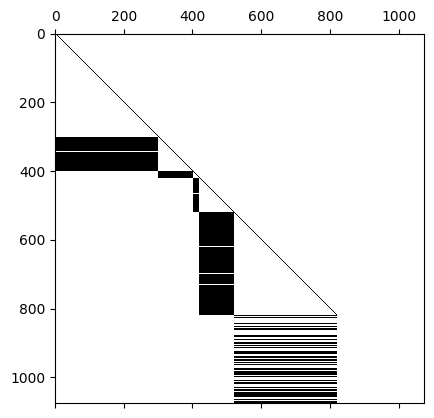

In [37]:
# Jacobian for Z-step
plt.spy(J)
plt.show()

Trained model reconstruction results:


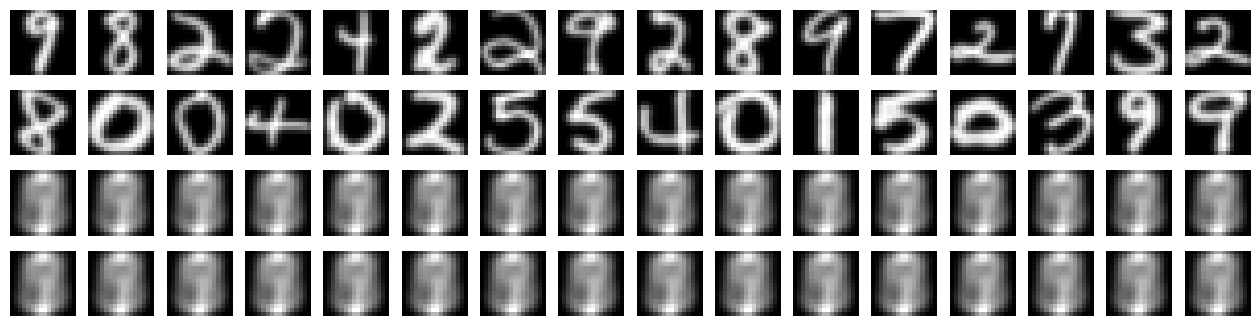

In [39]:
for x, _ in train_loader:
    x = x[:32].to(device)
    with torch.no_grad():
        z = model(x)
    
    print('Trained model reconstruction results:')
    plot_progress(x, z)
    
    break